In [1]:
import numpy as np

import sys
sys.path.append("/home/mayajas/Documents/programs/prfpy-main")

from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, DoG_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, DoG_Iso2DGaussianFitter

import os
from os.path import join as opj
import scipy.io

import nibabel as nib

import matplotlib.pyplot as plt

import nilearn
from nilearn import plotting, datasets, image
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_roi

import pickle
import pandas as pd

import itertools

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures

import random

from scipy import stats

import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# from transformations import quaternion_from_matrix, euler_from_quaternion

import nipype.interfaces.fsl as fsl

# import glob
import math 

from scipy.spatial import KDTree


import numpy.matlib

import seaborn as sb

from scipy.stats import gaussian_kde



/home/mayajas/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/mayajas/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


230612-12:18:00,247 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


#### General directories and settings

In [2]:
subject_list = ['sub-01','sub-02','sub-03','sub-04']
hem_list     = ['lh','rh']
roi_list     = ['V1','V2','V3','V4']

space        = 'surf'

fit_hrf        = True  # boolean, optional
                              # Whether or not to fit two extra parameters for hrf derivative and
                              # dispersion. The default is False.
start_from_avg = True   # whether to use avg across depths as starting point for layer fits

if space == 'surf':
    prf_model     = 'prfpy_fit_hrf_'+str(fit_hrf)+'_start_from_avg_'+str(start_from_avg)
elif space == 'vol':
    prf_model     = 'prfpy_vol_fit_hrf_'+str(fit_hrf)


proj_dir     = '/home/mayajas/scratch/project-00-7t-pipeline-dev/'
prfpy_dir    = '/home/mayajas/scratch/project-00-7t-pipeline-dev/output/'+prf_model+'/'

report_dir   = '/home/mayajas/Documents/project-00-7t-pipeline-dev/reports/figures'

# dataframe outputs of pRF_getSigmas.py
df_layers_fn = opj(prfpy_dir,'df_prf_param')

In [3]:
prf_model

'prfpy_fit_hrf_True_start_from_avg_True'

In [4]:
screen_size_cm     = 12.0
screen_distance_cm = 52.0
TR                 = 3.0
#design_matrix      = mat["stim"]

max_ecc = math.atan(screen_size_cm/screen_distance_cm)/2
max_ecc_deg = math.degrees(max_ecc)

print("Max eccentricity of stimulus is "+str(round(max_ecc_deg,2)))

Max eccentricity of stimulus is 6.5


Set number of layers, eccentricities, subjects, hemispheres, ROIs

In [5]:
rsq_thresh = 0.15
n_layers   = 6
n_sub      = len(subject_list)
n_hem      = len(hem_list)
n_rois     = 4


#### Useful functions

In [6]:
def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)], abs(data - np.mean(data)) < m * np.std(data)

In [7]:
def reject_outliers_median(data, m=3.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / (mdev if mdev else 1.)
    return data[s < m], s < m

In [8]:
def flatten(l):
    return [item for sublist in l for item in sublist]

# PRF size across cortical depth: all subjects

## Load data

In [9]:
f = open(df_layers_fn,'rb')
df_equivol_per_depth,df_equivol_per_depth_ecc2 = pickle.load(f)

f.close()

In [10]:
df_equivol_per_depth.head()

,sub id,roi,hem,layer,pRF size,ecc,hrf1,hrf2,rsq
0,sub-01,V1,lh,1.0,"[0.8575734005015493, 0.7842717772478546, 0.857...","[0.5398128340938704, 0.6219945016451918, 0.539...","[5.870829825831485, 5.155143236418062, 5.87082...","[14.894460351875756, 5.444203403220776, 14.894...","[0.6191138431779514, 0.6578103458163742, 0.619..."
1,sub-01,V1,lh,2.0,"[0.8538105545122688, 0.7457747401973148, 0.853...","[0.7485786987741747, 0.9590357388016704, 0.748...","[9.69279499129853, 2.9642953385088275, 9.69279...","[4.7784815276479335, 2.3250170814268682, 4.778...","[0.4606358195447249, 0.6455237974407702, 0.460..."
2,sub-01,V1,lh,3.0,"[0.8538105545122688, 0.7933531508633441, 0.835...","[0.7485786987741747, 1.227435666791189, 1.0340...","[9.69279499129853, 13.23711165981319, 9.233799...","[4.7784815276479335, 12.25521242627558, 4.6765...","[0.4606358195447249, 0.30139565715280736, 0.41..."
3,sub-01,V1,lh,4.0,"[1.5474392858323405, 0.7933531508633441, 0.835...","[6.375267639557535, 1.227435666791189, 1.03400...","[-0.9730932977800174, 13.23711165981319, 9.233...","[-4.276619694220091, 12.25521242627558, 4.6765...","[0.13968351569661985, 0.30139565715280736, 0.4..."
4,sub-01,V1,lh,5.0,"[0.4116304280497383, 0.7933531508633441, 0.835...","[6.567749063410855, 1.227435666791189, 1.03400...","[-1.4786985856475958, 13.23711165981319, 9.233...","[0.6116408278113864, 12.25521242627558, 4.6765...","[0.13918423981326666, 0.30139565715280736, 0.4..."


In [11]:
df_equivol_per_depth_ecc2.head()

,sub id,roi,hem,layer,pRF size,ecc,hrf1,hrf2,rsq
0,sub-01,V1,lh,1.0,"[nan, 1.1855017350649355, nan, 1.0571209523407...","[nan, 2.8301120401210578, nan, 2.2105665638603...","[nan, 4.02939042843354, nan, 3.659055898778253...","[nan, 0.6725819726628574, nan, -1.033235126191...","[0.0, 0.5646012953888018, 0.0, 0.7274241329266..."
1,sub-01,V1,lh,2.0,"[nan, 1.1855017350649355, 0.982553117814458, 1...","[nan, 2.8301120401210578, 2.653922161908736, 2...","[nan, 4.02939042843354, 3.8127267851001116, 3....","[nan, 0.6725819726628574, 5.251440275733433, 0...","[0.0, 0.5646012953888018, 0.5211255220517409, ..."
2,sub-01,V1,lh,3.0,"[1.6140139289715316, 1.6186398011898637, 0.982...","[3.8049052108735397, 3.480672698546255, 2.6539...","[8.910476297687495, 12.35619641577554, 3.81272...","[2.735419306008783, 6.888632952370142, 5.25144...","[0.5691901270251605, 0.5686658188838504, 0.521..."
3,sub-01,V1,lh,4.0,"[1.6140139289715316, 1.6186398011898637, 0.982...","[3.8049052108735397, 3.480672698546255, 2.6539...","[8.910476297687495, 12.35619641577554, 3.81272...","[2.735419306008783, 6.888632952370142, 5.25144...","[0.5691901270251605, 0.5686658188838504, 0.521..."
4,sub-01,V1,lh,5.0,"[1.6140139289715316, 1.572517379493541, 0.9825...","[3.8049052108735397, 3.6358486268623613, 2.653...","[8.910476297687495, 14.268777593721051, 3.8127...","[2.735419306008783, 9.509629508574319, 5.25144...","[0.5691901270251605, 0.49891190143216757, 0.52..."


## PRF size per cortical layer fitted at target eccentricity

#### pRF size as a function of eccentricity (separately for each cortical layer)
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Thresholds

In [12]:
target_ecc = 2
pRF_thresh = max_ecc_deg

In [13]:
np.linspace(1,n_layers,n_layers).tolist()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

Create a dataframe to save intercept and slope stats

In [14]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

intercept = np.empty((1,len(subs),)).tolist()
intercept = list(itertools.chain(*intercept))

slope = np.empty((1,len(subs),)).tolist()
slope = list(itertools.chain(*slope))

intercept_stats = np.empty((1,len(subs),)).tolist()
intercept_stats = list(itertools.chain(*intercept_stats))

slope_stats = np.empty((1,len(subs),)).tolist()
slope_stats = list(itertools.chain(*slope_stats))

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equivol = pd.DataFrame({
    'sub id' : subs,
    'layer' : depths,
    'intercept': intercept,
    'slope': slope,
    'intercept-stats' : intercept_stats,
    'slope-stats' : slope_stats,
    'pRF@2deg': pRF_2deg
})

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


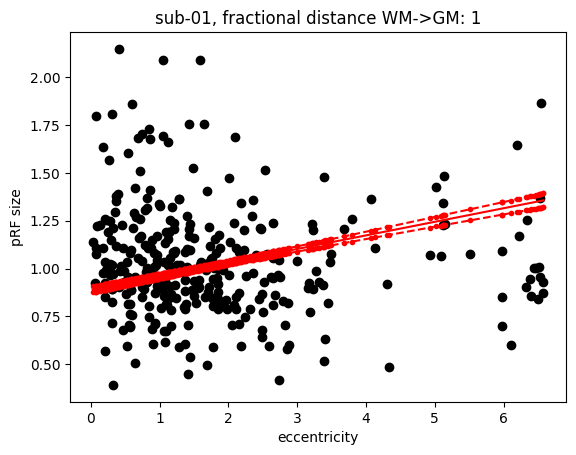

Intercept: 0.8890141337667224
t = 112.30, p = 0.00000
Slope: 0.0710879076429045
t = 19.53, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


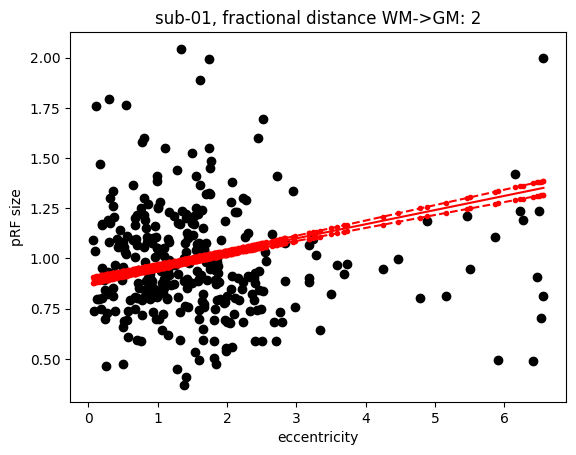

Intercept: 0.8882878744736116
t = 116.24, p = 0.00000
Slope: 0.07059168199136381
t = 20.30, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


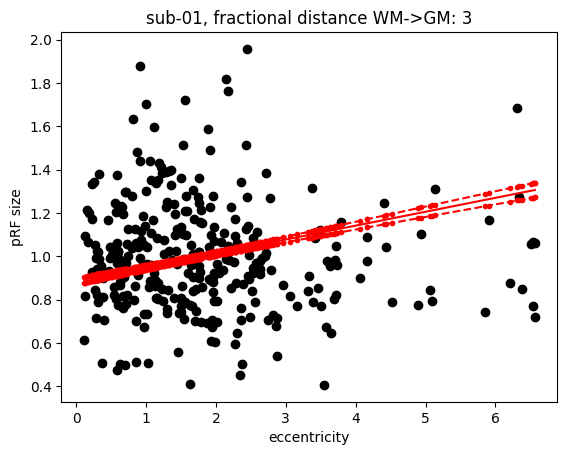

Intercept: 0.8852640159631677
t = 120.21, p = 0.00000
Slope: 0.06410206518275716
t = 18.82, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


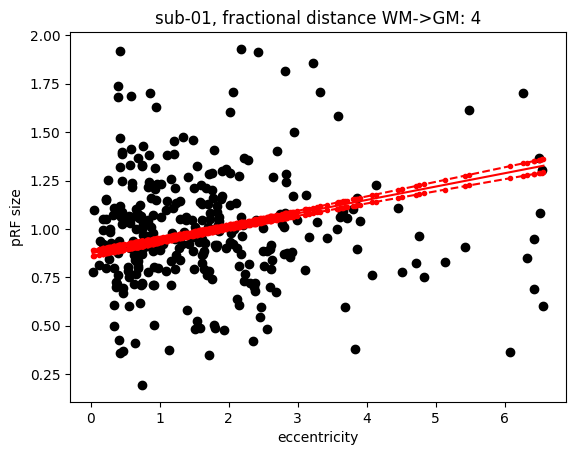

Intercept: 0.8736808664688621
t = 112.47, p = 0.00000
Slope: 0.06900086979508943
t = 19.78, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


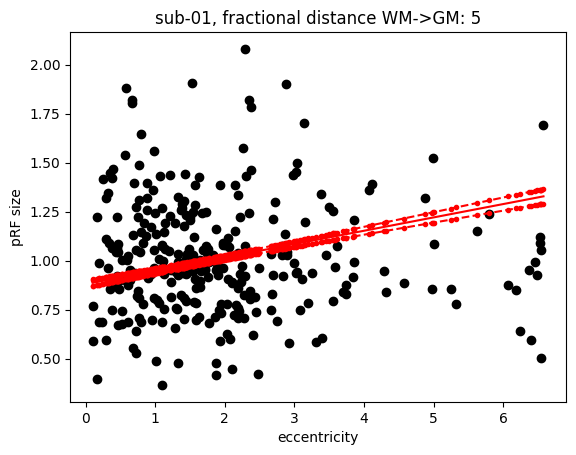

Intercept: 0.8798598736351808
t = 100.40, p = 0.00000
Slope: 0.06807306071430926
t = 17.80, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


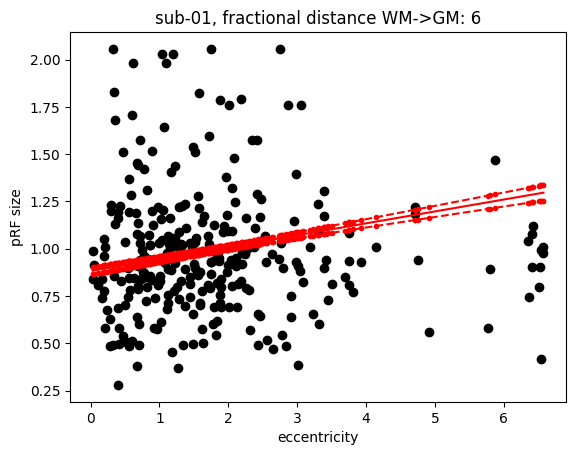

Intercept: 0.8825837984134385
t = 88.45, p = 0.00000
Slope: 0.06295844883063537
t = 14.81, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


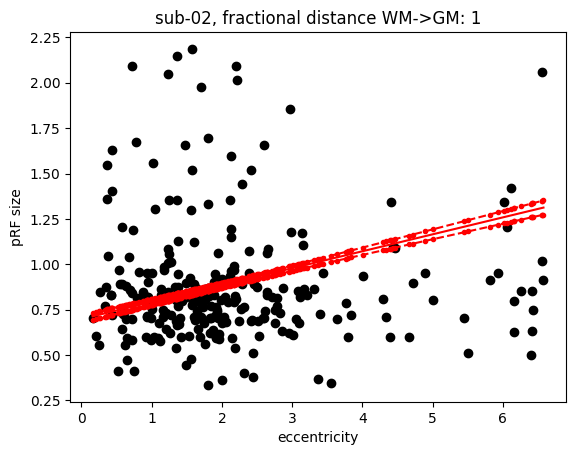

Intercept: 0.6984905229782772
t = 63.43, p = 0.00000
Slope: 0.09328204189703349
t = 21.95, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


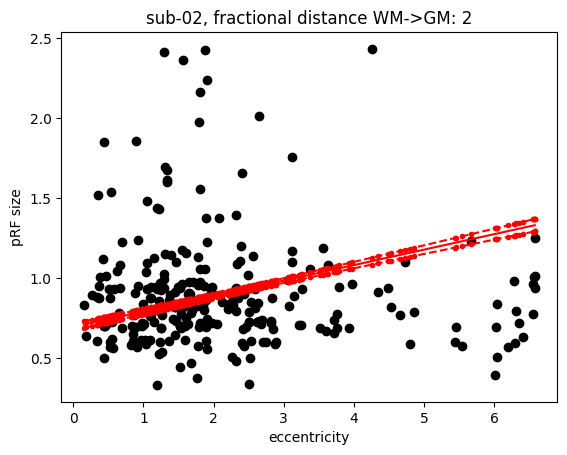

Intercept: 0.6955068910440501
t = 63.13, p = 0.00000
Slope: 0.09668155057794373
t = 22.94, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


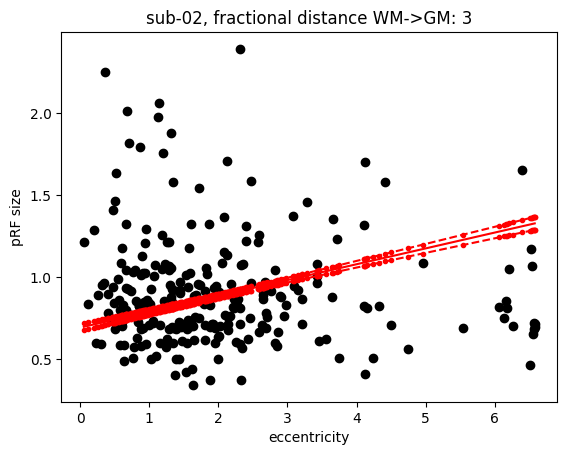

Intercept: 0.6918732500726259
t = 62.56, p = 0.00000
Slope: 0.09661695421756429
t = 22.49, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


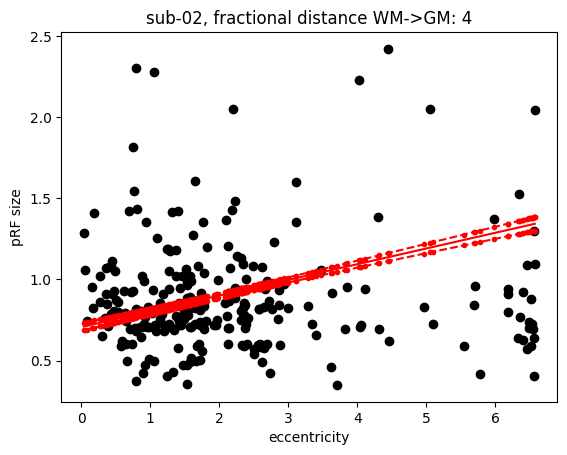

Intercept: 0.7069211628510633
t = 59.02, p = 0.00000
Slope: 0.09675873529027589
t = 21.22, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


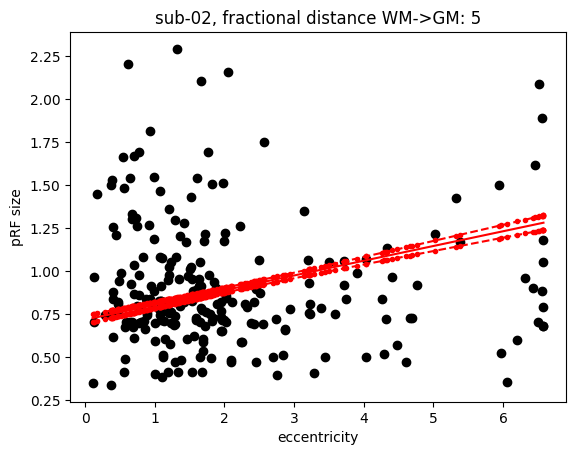

Intercept: 0.7180720112617734
t = 59.02, p = 0.00000
Slope: 0.08560856287979784
t = 18.74, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


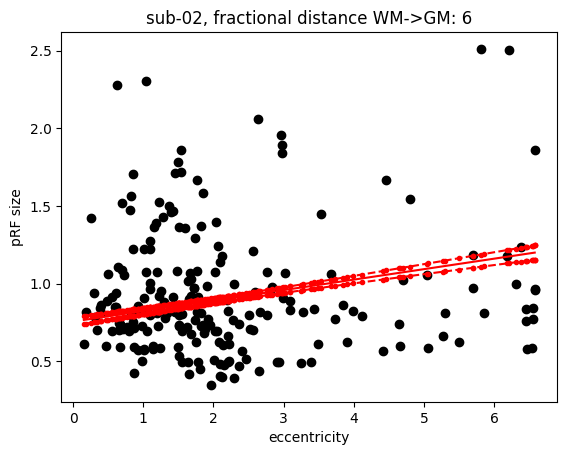

Intercept: 0.7571049707795362
t = 55.29, p = 0.00000
Slope: 0.067404479722455
t = 13.33, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


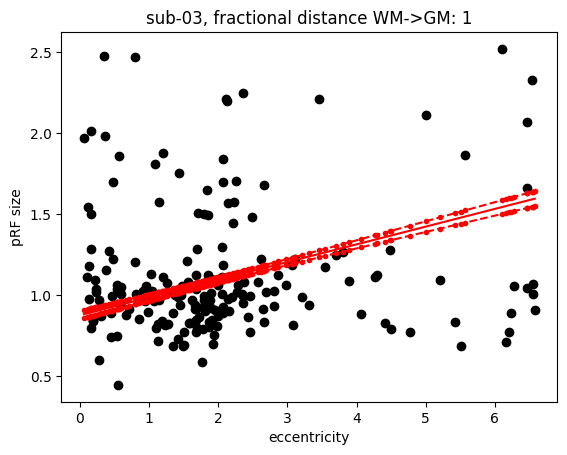

Intercept: 0.8774654999054137
t = 68.79, p = 0.00000
Slope: 0.10921154731169236
t = 22.40, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


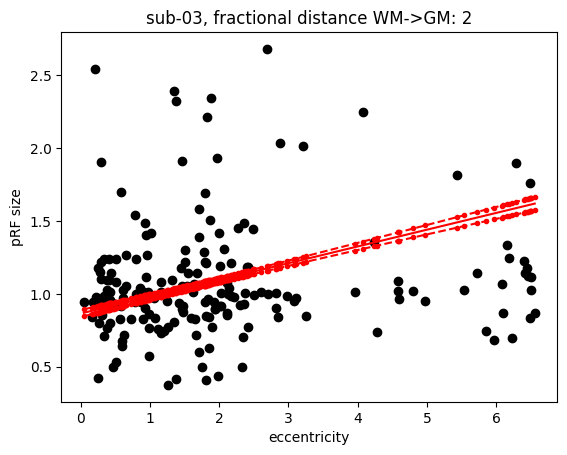

Intercept: 0.8646708930840554
t = 70.70, p = 0.00000
Slope: 0.11515444795014387
t = 24.02, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


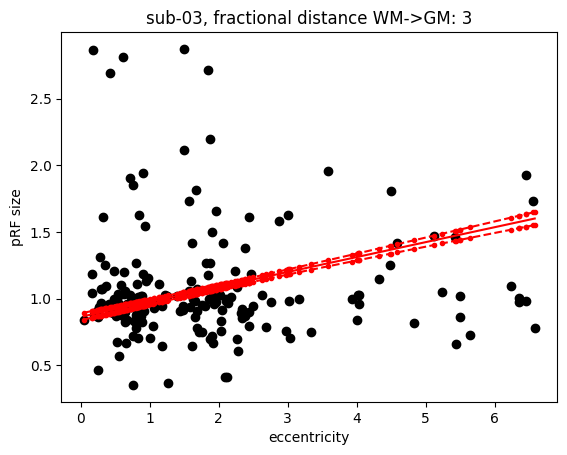

Intercept: 0.863239208222168
t = 65.10, p = 0.00000
Slope: 0.11204184949217448
t = 21.88, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


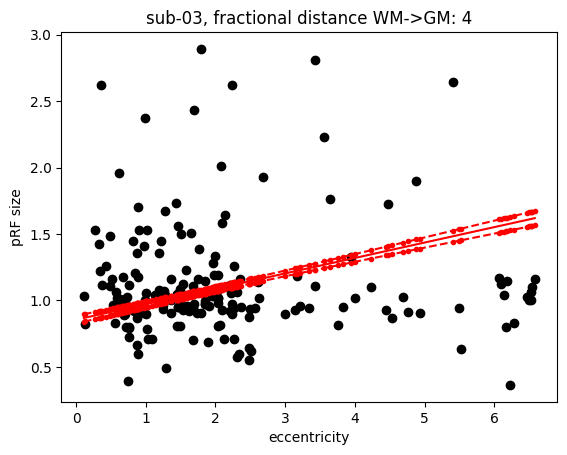

Intercept: 0.8551757852775057
t = 57.73, p = 0.00000
Slope: 0.11607878897048332
t = 20.17, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


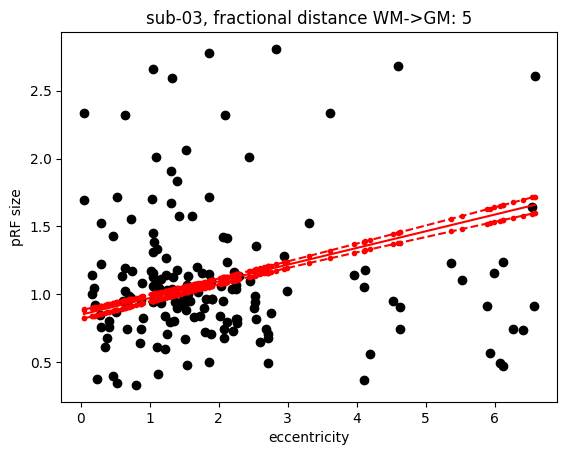

Intercept: 0.8491972087440507
t = 49.93, p = 0.00000
Slope: 0.12302303439408166
t = 19.23, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


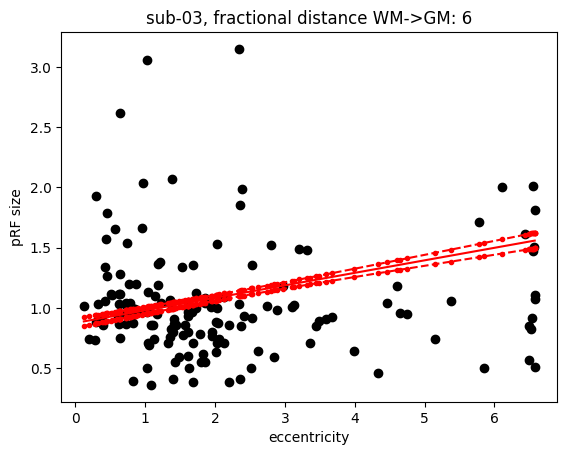

Intercept: 0.8742456171566624
t = 45.45, p = 0.00000
Slope: 0.10402335904378467
t = 14.91, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


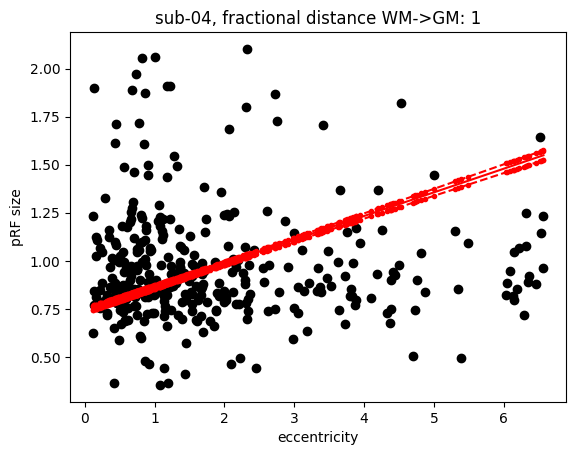

Intercept: 0.7409130609723611
t = 128.05, p = 0.00000
Slope: 0.12306013205565511
t = 48.29, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


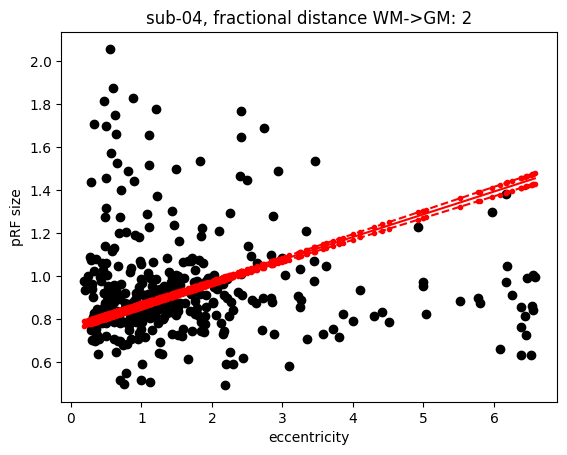

Intercept: 0.7589366737759619
t = 135.59, p = 0.00000
Slope: 0.10564038905567177
t = 42.80, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


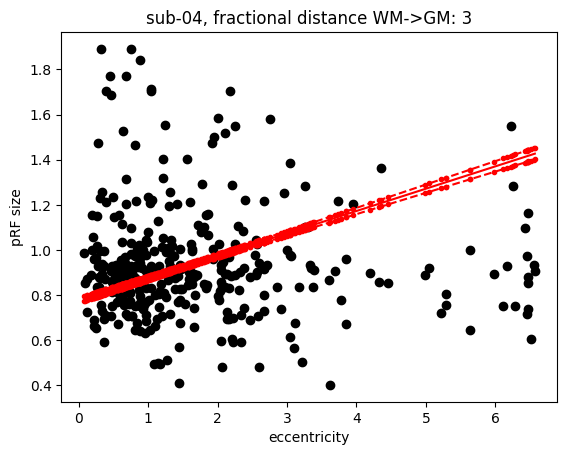

Intercept: 0.7768798095267412
t = 133.58, p = 0.00000
Slope: 0.0989100889251825
t = 38.20, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


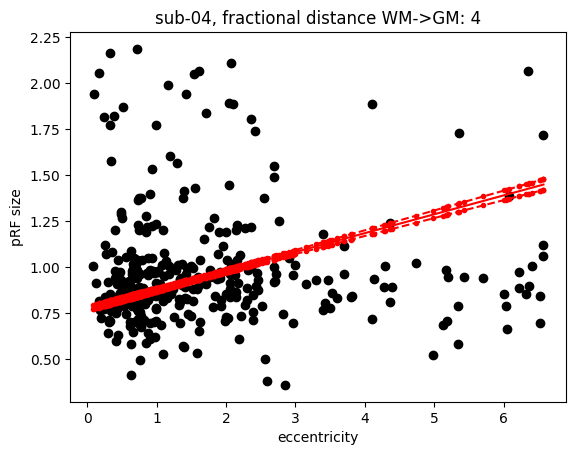

Intercept: 0.7731357750594766
t = 120.44, p = 0.00000
Slope: 0.10264283816685735
t = 35.28, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


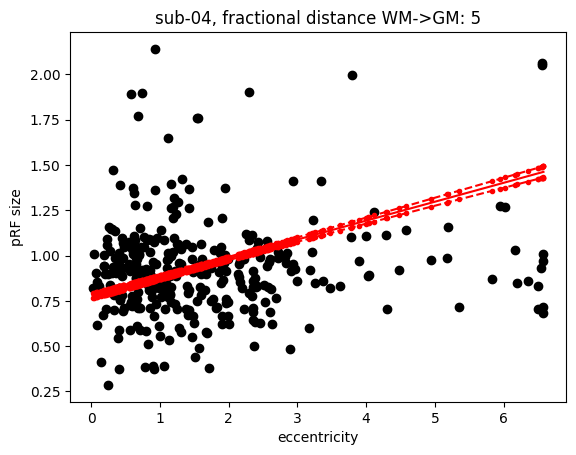

Intercept: 0.7753983090661258
t = 109.72, p = 0.00000
Slope: 0.10439402492139563
t = 33.41, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


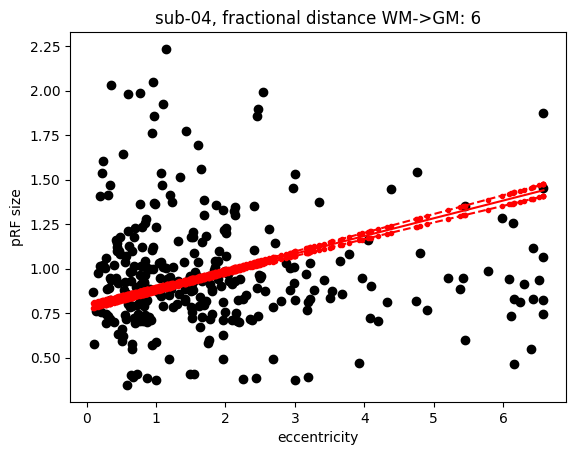

Intercept: 0.785046122956321
t = 97.93, p = 0.00000
Slope: 0.09960425909032561
t = 29.31, p = 0.00000


In [15]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(subject_list[sub_id])
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        # lh
        idx=df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'lh') & 
                                     (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['layer'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'rh') & 
                                            (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['layer'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

#         y_sigma = lh_sigma
#         x_ecc = lh_ecc
#         r2 = lh_rsq

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
#         # bin eccentricity data
#         bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
#         x_ecc=np.digitize(x_ecc,bins=bins)

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]
    
        if len(y_sigma) < 20:
            idx=df_pRFxecc_stats_equivol.loc[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol['layer'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_equivol.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
            continue


        # Split the data into a training set and a test set
        X_train, X_test, y_train, y_test = train_test_split(x_ecc, y_sigma, test_size=0.1)

        # Fit the model to the training set
        X_train = sm.add_constant(X_train)
        #model = sm.OLS(y_train, X_train).fit()
        model = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit()

        # Make predictions on the test set
        X_test = sm.add_constant(X_test)
        y_pred = model.predict(X_test)

        # extract the prediction
        pred = model.get_prediction(X_test)

        # extract the intercept and slope
        intercept = model.params[0]
        slope = model.params[1]

        # extract the bootstrapped 95% quantiles and median of the fit
        quantiles = pred.summary_frame(alpha=0.05)
        median = pred.summary_frame(alpha=0.5)

        # plot the model
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_test), 'ko')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_pred), 'r-')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_lower'].values), 'r--.')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_upper'].values), 'r--.')
        plt.xlabel('eccentricity')
        plt.ylabel('pRF size')
        plt.title(subject_list[sub_id]+", fractional distance WM->GM: "+"{0:.2g}".format(depth_idx))
                  #str(depth_idx/10))
        plt.show()

        # print stats
        print(f"Intercept: {intercept}")
        intercept_txt = "t = "+"{:.2f}".format(model.tvalues[0])+", p = "+"{:.5f}".format(model.pvalues[0])
        print(intercept_txt)

        print(f"Slope: {slope}")
        slope_txt = "t = "+"{:.2f}".format(model.tvalues[1])+", p = "+"{:.5f}".format(model.pvalues[1])
        print(slope_txt)

        # get pRF estimate at 2deg
        pRF_est = intercept + target_ecc*slope

    #     # print the quantiles
    #     print("95% quantiles:")
    #     print(quantiles.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

    #     # print the median
    #     print("Median:")
    #     print(median.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

        # save stats to df
        idx=df_pRFxecc_stats_equivol.loc[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol['layer'] == depth_idx)].index.tolist()
        df_pRFxecc_stats_equivol.loc[idx, 'intercept-stats'] = pd.Series([intercept_txt]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
        df_pRFxecc_stats_equivol.loc[idx, 'slope-stats'] = pd.Series([slope_txt]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])

        df_pRFxecc_stats_equivol.loc[idx, 'intercept'] = pd.Series([intercept]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
        df_pRFxecc_stats_equivol.loc[idx, 'slope'] = pd.Series([slope]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])

        df_pRFxecc_stats_equivol.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
        
    

In [16]:
df_pRFxecc_stats_equivol.head()


,sub id,layer,intercept,slope,intercept-stats,slope-stats,pRF@2deg
0,sub-01,1.0,0.889014,0.071088,"t = 112.30, p = 0.00000","t = 19.53, p = 0.00000",1.031190
1,sub-01,2.0,0.888288,0.070592,"t = 116.24, p = 0.00000","t = 20.30, p = 0.00000",1.029471
2,sub-01,3.0,0.885264,0.064102,"t = 120.21, p = 0.00000","t = 18.82, p = 0.00000",1.013468
3,sub-01,4.0,0.873681,0.069001,"t = 112.47, p = 0.00000","t = 19.78, p = 0.00000",1.011683
4,sub-01,5.0,0.879860,0.068073,"t = 100.40, p = 0.00000","t = 17.80, p = 0.00000",1.016006


#### Plot estimated pRF size at target eccentricity

[ 9.35231832e-04 -1.09931238e-02  1.04267802e+00]
R2 quadratic: 0.824362704199264
R2 linear: 0.7532720752215184
[-6.33921643e-04  5.89132369e-03  8.79107088e-01]
R2 quadratic: 0.31950250940047886
R2 linear: 0.22730995092842154
[ 3.67232259e-05 -2.17650186e-03  1.09757083e+00]
R2 quadratic: 0.4055839227941238
R2 linear: 0.4052674522182782
[ 0.00159911 -0.01028708  0.99155377]
R2 quadratic: 0.5202897606453507
R2 linear: 0.06813976165941782


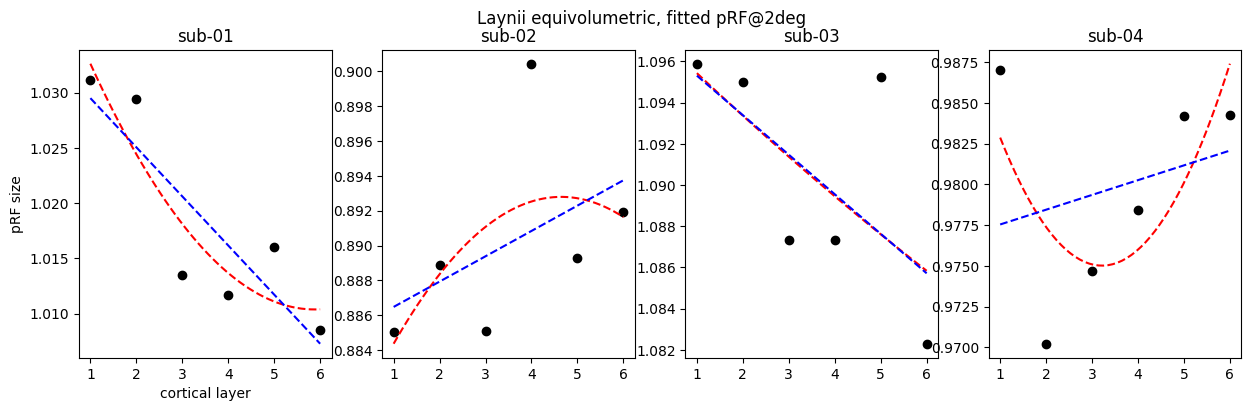

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))


for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equivol.loc[idx,'layer'].values
    pRF_2deg = df_pRFxecc_stats_equivol.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(1, n_layers, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.6, 1.0])
#     axs[sub_id].set_yticks(np.linspace(0.6,1.0,5)) 
#     axs[sub_id].set_ylim([0.65, 0.9])
#     axs[sub_id].set_yticks(np.linspace(0.65,0.9,6))  
    
plt.suptitle('Laynii equivolumetric, fitted pRF@2deg')
plt.show()
    


##### Group plot

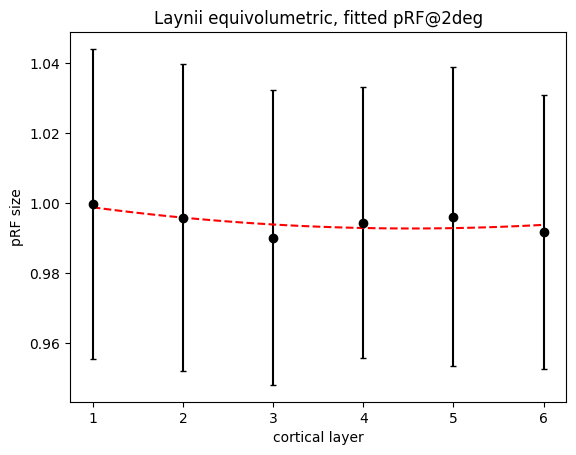

In [18]:
idx      = df_pRFxecc_stats_equivol[(df_pRFxecc_stats_equivol['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equivol.loc[idx,'layer'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_equivol['layer'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equivol.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)

# data for plot
depth_plot    = df_pRFxecc_stats_equivol.loc[:,'layer'].values
pRF_2deg_plot = df_pRFxecc_stats_equivol.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
# plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.title('Laynii equivolumetric, fitted pRF@2deg')
plt.show()

## PRF size per cortical layer fitted at manually-defined iso-eccentricity band

### Equivolumetric layering

#### pRF size as a function of eccentricity
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

Extract lh and rh sigma and ecc values at chosen rsq threshold

In [19]:
target_ecc = 2
pRF_thresh = max_ecc_deg

Create a dataframe to save intercept and slope stats

In [20]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equivol_2ecc = pd.DataFrame({
    'sub id' : subs,
    'layer' : depths,
    'pRF@2deg': pRF_2deg
})

In [21]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        # lh
        idx=df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                          (df_equivol_per_depth_ecc2['roi'] == 'V1') & 
                                    (df_equivol_per_depth_ecc2['hem'] == 'lh') & 
                                    (df_equivol_per_depth_ecc2['layer'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                                 (df_equivol_per_depth_ecc2['roi'] == 'V1') & 
                                    (df_equivol_per_depth_ecc2['hem'] == 'rh') & 
                                    (df_equivol_per_depth_ecc2['layer'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

#         y_sigma = lh_sigma
#         x_ecc = lh_ecc
#         r2 = lh_rsq

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
        # bin eccentricity data
        bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        x_ecc=np.digitize(x_ecc,bins=bins)

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol_2ecc['layer'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])
            continue


        # get pRF estimate at 2deg
        pRF_est = np.mean(y_sigma)


        # save stats to df
        idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol_2ecc['layer'] == depth_idx)].index.tolist()

        df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])
        
    

In [22]:
df_pRFxecc_stats_equivol_2ecc.head()


,sub id,layer,pRF@2deg
0,sub-01,1.0,0.991640
1,sub-01,2.0,0.987455
2,sub-01,3.0,0.987199
3,sub-01,4.0,0.990162
4,sub-01,5.0,0.984378


#### Plot estimated pRF size at target eccentricity

[ 0.00162572 -0.00996147  1.00081806]
R2 quadratic: 0.6349473421123039
R2 linear: 0.16700665642637857
[ 0.00201351 -0.00798817  0.85351119]
R2 quadratic: 0.8378689365591022
R2 linear: 0.6801150566410152
[4.73687839e-04 1.28728473e-03 1.08318507e+00]
R2 quadratic: 0.366056280210468
R2 linear: 0.3579692663816604
[ 0.00600367 -0.03493558  1.00402398]
R2 quadratic: 0.950105195120936
R2 linear: 0.37559127344133947


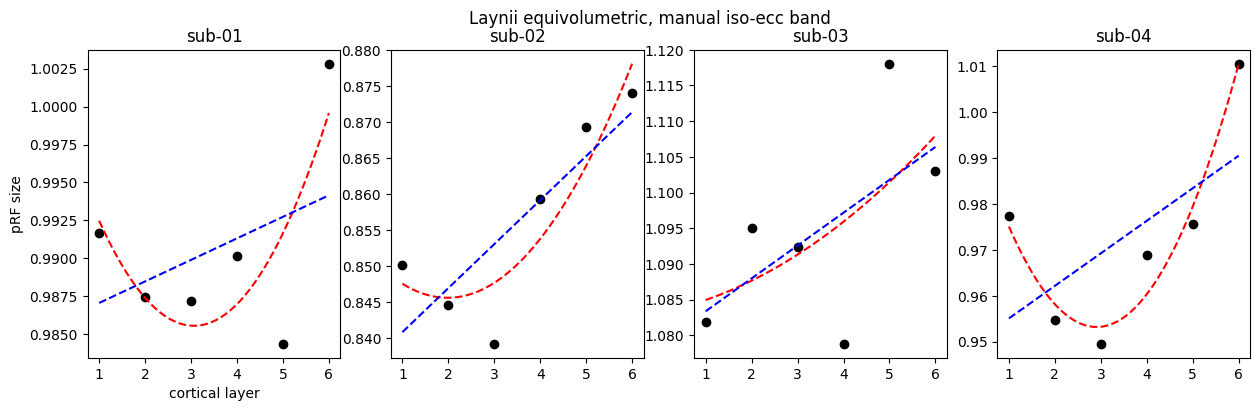

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))


for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'layer'].values
    pRF_2deg = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(1, n_layers, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.65, 1.15])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.15,6))  
#     axs[sub_id].set_ylim([0.65, 1.05])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.05,5)) 
    
plt.suptitle('Laynii equivolumetric, manual iso-ecc band')
plt.show()


##### Group plot

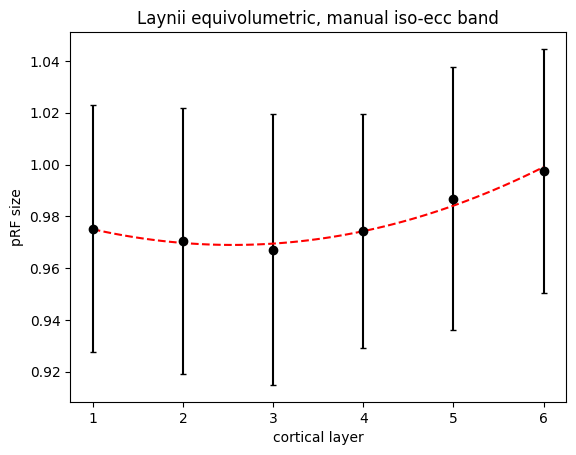

In [24]:
idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'layer'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_equivol_2ecc['layer'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)

# ################################################
# # Fit the quadratic equation
# coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)

# # Fit the linear equation
# coefs_linear = np.polyfit(depth, pRF_2deg, 1)

# # # Create a polynomial function from the coefficients
# # f_quadratic = np.poly1d(coefs_quadratic)
# # f_linear = np.poly1d(coefs_linear)

# # # calculate the R-squared
# # r_squared = r2_score(pRF_2deg, f_quadratic(depth))
# # print(f"R2 quadratic: {r_squared}")
# # r_squared = r2_score(pRF_2deg, f_linear(depth))
# # print(f"R2 linear: {r_squared}")
# #################################################

# data for plot
depth_plot    = df_pRFxecc_stats_equivol_2ecc.loc[:,'layer'].values
pRF_2deg_plot = df_pRFxecc_stats_equivol_2ecc.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
#plt.plot(X_plot/n_layers,y_median,'b--')
# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')
plt.title('Laynii equivolumetric, manual iso-ecc band')
plt.show()


# ######################################################

# ######################################################

# Pooling data from all participants

Thresholds

In [25]:
target_ecc = 2
pRF_thresh = max_ecc_deg

In [26]:
n_layers

6

In [27]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth  = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRF_filtered_equivol = pd.DataFrame({
    'sub id' : subs,
    'layer' : depths,
    'pRFs': pRF_2deg
})

In [28]:
for depth_idx in depth:
    for sub_id in range(0,len(subject_list)):
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(subject_list[sub_id])
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        # lh
        idx=df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'lh') & 
                                     (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['layer'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'rh') & 
                                            (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['layer'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
        print('Nr voxels at layer '+str(depth_idx)+': '+str(len(y_sigma)))
        
        
         # save stats to df
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                (df_pRF_filtered_equivol['layer'] == depth_idx)].index.tolist()

        df_pRF_filtered_equivol.loc[idx, 'pRFs'] = pd.Series([y_sigma], index=df_pRF_filtered_equivol.index[idx])

        

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 3197
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 2592
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 1895
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 3480
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 2.0: 3213
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%

In [29]:
df_pRF_filtered_equivol.head()

,sub id,layer,pRFs
0,sub-01,1.0,"[[0.8575734005015493], [0.7842717772478546], [..."
1,sub-01,2.0,"[[0.8538105545122688], [0.7457747401973148], [..."
2,sub-01,3.0,"[[0.8538105545122688], [0.7933531508633441], [..."
3,sub-01,4.0,"[[0.7933531508633441], [0.83553332257952], [0...."
4,sub-01,5.0,"[[0.7933531508633441], [0.83553332257952], [0...."


In [30]:
all_sigma_list = []
all_pos_list = []

for depth_idx in depth:
    sigmas_thisdepth = []
    for sub_id in range(0,len(subject_list)):
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRF_filtered_equivol['layer'] == depth_idx)].index.tolist()
        sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
    all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
    all_pos_list.append(depth_idx)

In [31]:
pRFsizes = all_sigma_list

In [32]:
# prctl = 50
# kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
# bw = "scott"  # "scott", "normal_reference", "silverman"
# adj = 6

# sigmas = np.zeros((len(depth),4))
# score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
# #good_idx = [0,1,2,4,5,6,7]

# fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
# for n in range(0,len(depth)):
#     X = pRFsizes[n]
#     dens = sm.nonparametric.KDEUnivariate(X)
#     dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
#     ax[n].plot(dens.support,dens.density)
#     s = dens.support
#     idx = np.argmax(dens.density)
#     #print(s[idx])
#     sigmas[n,0] = np.mean(X)
#     sigmas[n,1] = np.mean(dens.support)
#     sigmas[n,2] = np.percentile(dens.support,prctl)
#     sigmas[n,3] = s[idx]
# ax[2].set_ylabel('probability density', fontsize=14)
# ax[len(depth)-1].set_xlabel('pRF size', fontsize=14)


# fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
# for n in range(4):
#     ax[n].plot(sigmas[:,n])
#     ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
#     if n !=3 :
#         ax[n].set_xticklabels([])
# ax[3].set_xlabel('Depths (relative index)', fontsize=14)

# ALL ROIS

## PRF per cortical layer fitted at manually-defined iso-eccentricity band

### Equivolumetric layering

#### pRF size as a function of eccentricity
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

Thresholds

In [33]:
target_ecc = 2
pRF_thresh = max_ecc_deg

In [34]:
np.linspace(1,n_layers,n_layers).tolist()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

Create a dataframe to save intercept and slope stats

In [35]:
subs = [['sub-01']*n_layers*n_rois,['sub-02']*n_layers*n_rois,['sub-03']*n_layers*n_rois,['sub-04']*n_layers*n_rois]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub*n_rois

rois = [['V1']*n_layers,['V2']*n_layers,['V3']*n_layers,['V4']*n_layers]
rois = list(itertools.chain(*rois))*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equivol_2ecc = pd.DataFrame({
    'sub id' : subs,
    'roi' : rois,
    'layer' : depths,
    'pRF@2deg': pRF_2deg
})

In [36]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        for roi_id in range(0,len(roi_list)):
            # lh
            idx=df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'lh') & 
                                        (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['layer'] == depth_idx)].index.tolist()
            lh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            lh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            lh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # rh
            idx      = df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'rh') & 
                                        (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['layer'] == depth_idx)].index.tolist()
            rh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            rh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            rh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # concatenate lh&rh
            y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
            x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
            r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

    #         y_sigma = lh_sigma
    #         x_ecc = lh_ecc
    #         r2 = lh_rsq

            # threshold by r2
            y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
            x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T

            # threshold by sigma (only positive)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

            # threshold by sigma (below threshold)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T


            # also remove outliers
            y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
            y_sigma            = y_sigma[idx_or,:]
            x_ecc              = x_ecc[idx_or,:]

            # bin eccentricity data
            bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
            x_ecc=np.digitize(x_ecc,bins=bins)

        #     # random shuffle
        #     shuffle_indices = np.random.permutation(len(y_sigma))
        #     y_sigma = y_sigma[shuffle_indices]
        #     x_ecc = x_ecc[shuffle_indices]

            if len(y_sigma) < 30:
                idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equivol_2ecc['layer'] == depth_idx) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
                df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])
                continue


            # get pRF estimate at 2deg
            pRF_est = np.mean(y_sigma)
            #pRF_est = np.median(y_sigma)


            # save stats to df
            idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equivol_2ecc['layer'] == depth_idx) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()

            df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])

    

In [37]:
df_pRFxecc_stats_equivol_2ecc.head()


,sub id,roi,layer,pRF@2deg
0,sub-01,V1,1.0,0.991640
1,sub-01,V1,2.0,0.987455
2,sub-01,V1,3.0,0.987199
3,sub-01,V1,4.0,0.990162
4,sub-01,V1,5.0,0.984378


#### Plot estimated pRF size at target eccentricity

In [38]:
pRF_2deg

[3.9150833e-316,
 0.0,
 5.247e-321,
 1.537e-321,
 4.88e-321,
 1.22e-321,
 4.88e-321,
 9.44e-322,
 4.88e-321,
 6.6e-322,
 5.247e-321,
 3.46e-322,
 5.563e-321,
 3.46e-322,
 5.88e-321,
 3.46e-322,
 6.245e-321,
 6.67e-322,
 6.245e-321,
 9.44e-322,
 6.245e-321,
 1.22e-321,
 5.884e-321,
 1.537e-321,
 5.133e-321,
 1.685e-321,
 4.857e-321,
 1.75e-321,
 4.545e-321,
 2.11e-321,
 4.545e-321,
 2.376e-321,
 4.545e-321,
 2.737e-321,
 5.09e-321,
 3.16e-321,
 5.563e-321,
 3.16e-321,
 6.037e-321,
 3.16e-321,
 6.58e-321,
 2.747e-321,
 6.58e-321,
 2.396e-321,
 6.58e-321,
 2.14e-321,
 6.275e-321,
 1.79e-321,
 6.003e-321,
 1.724e-321,
 6.314e-321,
 1.655e-321,
 6.66e-321,
 1.235e-321,
 6.66e-321,
 9.4e-322,
 6.66e-321,
 4.9e-322,
 6.09e-321,
 0.0,
 5.563e-321,
 0.0,
 5.035e-321,
 0.0,
 4.466e-321,
 4.74e-322,
 4.466e-321,
 9.14e-322,
 4.466e-321,
 1.21e-321,
 4.82e-321,
 1.616e-321,
 4.96e-321,
 2.347e-321,
 4.96e-321,
 2.13e-321,
 5.277e-321,
 1.88e-321,
 5.563e-321,
 1.88e-321,
 5.845e-321,
 1.88e-321,
 

[ 0.00162572 -0.00996147  1.00081806]
R2 quadratic: 0.6349473421123039
R2 linear: 0.16700665642637857
[-0.00147986  0.00202703  1.06703025]
R2 quadratic: 0.9094532747604545
R2 linear: 0.8521080750448923
[-0.00564081  0.02653217  1.23580047]
R2 quadratic: 0.9238008550709143
R2 linear: 0.6577219599177855
[-0.0048284  -0.00949708  1.49729241]
R2 quadratic: 0.8567361910265097
R2 linear: 0.8345926732769333
[ 0.00201351 -0.00798817  0.85351119]
R2 quadratic: 0.8378689365591022
R2 linear: 0.6801150566410152
[-0.00116564  0.02307411  0.87708751]
R2 quadratic: 0.8751799864300654
R2 linear: 0.8639227261501147
[-0.00103228  0.02743988  0.91274951]
R2 quadratic: 0.9758105119024268
R2 linear: 0.9704115920731384
[-6.01378992e-03  8.72525542e-04  1.36181852e+00]
R2 quadratic: 0.7467833700302815
R2 linear: 0.7143518676033287
[4.73687839e-04 1.28728473e-03 1.08318507e+00]
R2 quadratic: 0.366056280210468
R2 linear: 0.3579692663816604
[-0.00228563  0.0281381   1.05428545]
R2 quadratic: 0.7074739800127919

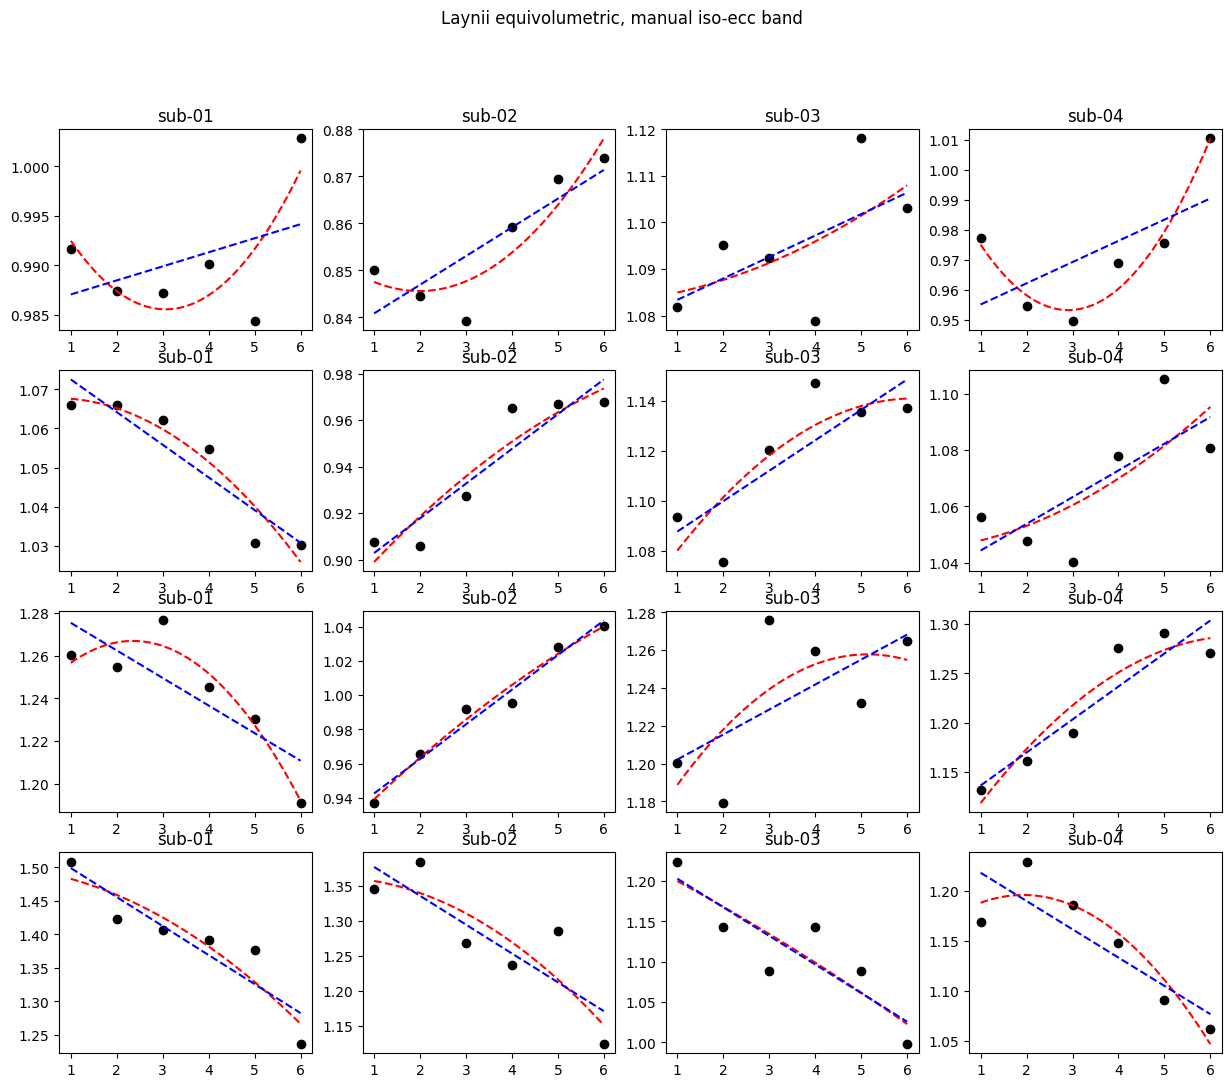

In [39]:
fig, axs = plt.subplots(nrows=len(roi_list), ncols=len(subject_list), figsize=(15, 12))

for sub_id in range(0,len(subject_list)):
    for roi_id in range(0,len(roi_list)):
        idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
        depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'layer'].values
        pRF_2deg = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values

        # omit nans
        idx = np.isfinite(pRF_2deg)
        pRF_2deg = pRF_2deg[idx]
        depth=depth[idx]

        try:
            # Fit the quadratic equation
            coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)

            # Fit the linear equation
            coefs_linear = np.polyfit(depth, pRF_2deg, 1)

            # Print the coefficients
            print(coefs_quadratic)

            # Create a polynomial function from the coefficients
            f_quadratic = np.poly1d(coefs_quadratic)
            f_linear = np.poly1d(coefs_linear)

            # calculate the R-squared
            r_squared = r2_score(pRF_2deg, f_quadratic(depth))
            print(f"R2 quadratic: {r_squared}")
            r_squared = r2_score(pRF_2deg, f_linear(depth))
            print(f"R2 linear: {r_squared}")

            # quadratic model fit
            #x = np.linspace(0.2, 0.9, 50)
            x = np.linspace(1, n_layers, 50)
            y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
            y_linear = coefs_linear[0]*x + coefs_linear[1]

            # plot the model
            axs[roi_id,sub_id].plot(depth,pRF_2deg,'ko')
            axs[roi_id,sub_id].plot(x,y_quadratic,'r--')
            axs[roi_id,sub_id].plot(x,y_linear,'b--')
            if sub_id == 0 & roi_id == len(roi_list)-1:
                axs[roi_id,sub_id].set_xlabel('cortical layer')
                axs[roi_id,sub_id].set_ylabel('pRF size')
            axs[roi_id,sub_id].set_title(subject_list[sub_id])
        except:
            print('no voxels')
    

plt.suptitle('Laynii equivolumetric, manual iso-ecc band')
plt.show()
    
#     df_pRFxecc_stats_equivol_2ecc.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equivol_per_depth['hem'] == 'lh') & 
#                                 (df_equivol_per_depth['layer'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

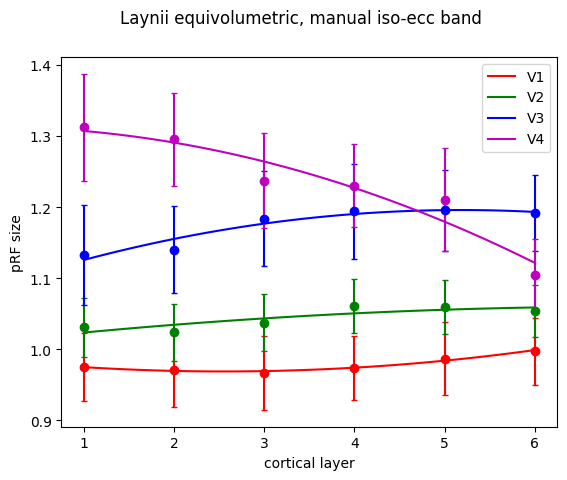

In [40]:
for roi_id in range(0,len(roi_list)):       
    idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[0]) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
    depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'layer'].values
    #depth    = depth[1:]
    pRF_2deg = np.empty((len(depth),len(subject_list)))

    for sub_id in range(0,len(subject_list)):
        idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                            (df_pRFxecc_stats_equivol_2ecc['layer'] >= np.min(depth)) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
        pRF_2deg[:,sub_id] = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values


    # omit nans
    idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
    pRF_2deg = pRF_2deg[idx,:]
    depth=depth[idx]

    # Transform the independent variable into a set of polynomial features
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(depth.reshape(-1,1))

    # Create and fit the model
    model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

    # Make predictions
    X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = model.predict(X_plot_poly)

    y_mean = y_plot.mean(axis=1)
    y_median = np.median(y_plot,axis=1)


    # data for plot
    depth_plot    = df_pRFxecc_stats_equivol_2ecc.loc[:,'layer'].values
    pRF_2deg_plot = df_pRFxecc_stats_equivol_2ecc.loc[:,'pRF@2deg'].values


    # plot
    if roi_id == 0:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='ro')
        line1=plt.plot(X_plot,y_mean,'r-')
    elif roi_id == 1:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='go')
        line2=plt.plot(X_plot,y_mean,'g-')
    elif roi_id == 2:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='bo')
        line3=plt.plot(X_plot,y_mean,'b-')
    elif roi_id == 3:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='mo')
        line4=plt.plot(X_plot,y_mean,'m-')
        
   
plt.legend(['V1', 'V2', 'V3','V4'])

plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.suptitle('Laynii equivolumetric, manual iso-ecc band')
plt.show()


# Pooling and max prob of fitted distribution

Set number of layers, eccentricities, subjects, hemispheres

Thresholds

In [41]:
target_ecc = 2
pRF_thresh = max_ecc_deg

In [42]:
subs = [['sub-01']*n_layers*n_rois,['sub-02']*n_layers*n_rois,['sub-03']*n_layers*n_rois,['sub-04']*n_layers*n_rois]
subs = list(itertools.chain(*subs))

depth  = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub*n_rois

rois = [['V1']*n_layers,['V2']*n_layers,['V3']*n_layers,['V4']*n_layers]
rois = list(itertools.chain(*rois))*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRF_filtered_equivol = pd.DataFrame({
    'sub id' : subs,
    'layer' : depths,
    'roi' : rois,
    'pRFs': pRF_2deg
})

In [43]:
for roi_id in range(0,len(roi_list)):  
    for depth_idx in depth:
        for sub_id in range(0,len(subject_list)):
            print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
            print(subject_list[sub_id])
            print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
            # lh
            idx=df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'lh') & 
                                         (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['layer'] == depth_idx)].index.tolist()
            lh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            lh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            lh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # rh
            idx      = df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'rh') & 
                                                (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['layer'] == depth_idx)].index.tolist()
            rh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            rh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            rh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # concatenate lh&rh
            y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
            x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
            r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

            # threshold by r2
            y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
            x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T

            # threshold by sigma (only positive)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

            # threshold by sigma (below threshold)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T


            # also remove outliers
            y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
            y_sigma            = y_sigma[idx_or,:]
            x_ecc              = x_ecc[idx_or,:]

            print('Nr voxels at layer '+str(depth_idx)+': '+str(len(y_sigma)))


             # save stats to df
            idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                    (df_pRF_filtered_equivol['layer'] == depth_idx) &
                                    (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()

            df_pRF_filtered_equivol.loc[idx, 'pRFs'] = pd.Series([y_sigma], index=df_pRF_filtered_equivol.index[idx])
        

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 1402
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 1198
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 878
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 1402
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 2.0: 1420
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%

Nr voxels at layer 1.0: 697
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 737
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 2.0: 920
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 2.0: 697
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 2.0: 701
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 2.0: 762
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [44]:
df_pRF_filtered_equivol.head(20)

,sub id,layer,roi,pRFs
0,sub-01,1.0,V1,"[[1.1855017350649355], [1.0571209523407428], [..."
1,sub-01,2.0,V1,"[[1.1855017350649355], [0.982553117814458], [1..."
2,sub-01,3.0,V1,"[[1.6140139289715316], [1.6186398011898637], [..."
3,sub-01,4.0,V1,"[[1.6140139289715316], [1.6186398011898637], [..."
4,sub-01,5.0,V1,"[[1.6140139289715316], [1.572517379493541], [0..."
5,sub-01,6.0,V1,"[[1.1464166941983385], [1.572517379493541], [1..."
6,sub-01,1.0,V2,"[[0.8316579541160612], [0.8153086193158905], [..."
7,sub-01,2.0,V2,"[[1.243789466368563], [1.3492233202142625], [0..."
8,sub-01,3.0,V2,"[[1.243789466368563], [1.3492233202142625], [0..."
9,sub-01,4.0,V2,"[[0.942509994047803], [0.940466312353762], [1...."


In [45]:
try:
    V1_all_sigma_list=np.load(opj(prfpy_dir,'V1_all_sigma_list_'+str(rsq_thresh)+'.npy'))
    V2_all_sigma_list=np.load(opj(prfpy_dir,'V2_all_sigma_list_'+str(rsq_thresh)+'.npy'))
    V3_all_sigma_list=np.load(opj(prfpy_dir,'V3_all_sigma_list_'+str(rsq_thresh)+'.npy'))
    V4_all_sigma_list=np.load(opj(prfpy_dir,'V4_all_sigma_list_'+str(rsq_thresh)+'.npy'))
except:
    V1_all_sigma_list = []
    V1_all_pos_list = []
    roi_id = 0

    for depth_idx in depth:
        sigmas_thisdepth = []
        for sub_id in range(0,len(subject_list)):
            idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                            (df_pRF_filtered_equivol['layer'] == depth_idx) &
                                            (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()
            sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
        V1_all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
        V1_all_pos_list.append(depth_idx)


    V2_all_sigma_list = []
    V2_all_pos_list = []
    roi_id = 1

    for depth_idx in depth:
        sigmas_thisdepth = []
        for sub_id in range(0,len(subject_list)):
            idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                            (df_pRF_filtered_equivol['layer'] == depth_idx) &
                                            (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()
            sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
        V2_all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
        V2_all_pos_list.append(depth_idx)

    V3_all_sigma_list = []
    V3_all_pos_list = []
    roi_id = 2

    for depth_idx in depth:
        sigmas_thisdepth = []
        for sub_id in range(0,len(subject_list)):
            idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                            (df_pRF_filtered_equivol['layer'] == depth_idx) &
                                            (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()
            sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
        V3_all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
        V3_all_pos_list.append(depth_idx)



    V4_all_sigma_list = []
    V4_all_pos_list = []
    roi_id = 3

    for depth_idx in depth:
        sigmas_thisdepth = []
        for sub_id in range(0,len(subject_list)):
            idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                            (df_pRF_filtered_equivol['layer'] == depth_idx) &
                                            (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()
            sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
        V4_all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
        V4_all_pos_list.append(depth_idx)

    np.save(opj(prfpy_dir,'V1_all_sigma_list_'+str(rsq_thresh)),V1_all_sigma_list)
    np.save(opj(prfpy_dir,'V2_all_sigma_list_'+str(rsq_thresh)),V2_all_sigma_list)
    np.save(opj(prfpy_dir,'V3_all_sigma_list_'+str(rsq_thresh)),V3_all_sigma_list)
    np.save(opj(prfpy_dir,'V4_all_sigma_list_'+str(rsq_thresh)),V4_all_sigma_list)

/home/mayajas/.conda/envs/py38prf/lib/python3.8/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Bootstrapping

In [46]:
# non-parametric fit parameters
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

# Set the number of bootstrap samples, depths
n_boot = 1000
n_depth = len(depth)


In [47]:
try:
    V1_maxprobs=np.load(opj(prfpy_dir,'V1_mean_maxprobs_'+str(rsq_thresh)+'.npy'))
    V2_maxprobs=np.load(opj(prfpy_dir,'V2_mean_maxprobs_'+str(rsq_thresh)+'.npy'))
    V3_maxprobs=np.load(opj(prfpy_dir,'V3_mean_maxprobs_'+str(rsq_thresh)+'.npy'))
    V4_maxprobs=np.load(opj(prfpy_dir,'V4_mean_maxprobs_'+str(rsq_thresh)+'.npy'))
except:
    
    # Create an array to store the maximum probability values
    V1_maxprobs = np.zeros([n_depth,n_boot,2])
    V2_maxprobs = np.zeros([n_depth,n_boot,2])
    V3_maxprobs = np.zeros([n_depth,n_boot,2])
    V4_maxprobs = np.zeros([n_depth,n_boot,2])

    # Generate bootstrap samples and calculate the maximum probability value for each sample
    # V1
    pRFsizes = V1_all_sigma_list
    print('V1 bootstrapping')
    for n in range(0,len(depth)):
            data = np.squeeze(pRFsizes[n])
            print('depth '+str(n))
            for i in range(n_boot):
                sample = np.random.choice(data, size=len(data), replace=True)

                # mean of sample
                V1_maxprobs[n,i,0] = np.mean(sample)
                
                # max prob of fitted nonparametric distribution
                dens = sm.nonparametric.KDEUnivariate(sample)
                dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj)
                
                s = dens.support
                idx = np.argmax(dens.density)
                V1_maxprobs[n,i,1] = s[idx]

    # V2
    pRFsizes = V2_all_sigma_list
    print('V2 bootstrapping')

    for n in range(0,len(depth)):
            data = np.squeeze(pRFsizes[n])
            print('depth '+str(n))
            for i in range(n_boot):
                sample = np.random.choice(data, size=len(data), replace=True)

                # mean of sample
                V2_maxprobs[n,i,0] = np.mean(sample)
                
                # max prob of fitted nonparametric distribution
                dens = sm.nonparametric.KDEUnivariate(sample)
                dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj)

                s = dens.support
                idx = np.argmax(dens.density)
                V2_maxprobs[n,i,1] = s[idx]

    # V3
    pRFsizes = V3_all_sigma_list
    print('V3 bootstrapping')

    for n in range(0,len(depth)):
            data = np.squeeze(pRFsizes[n])
            print('depth '+str(n))
            for i in range(n_boot):
                sample = np.random.choice(data, size=len(data), replace=True)

                # mean of sample
                V3_maxprobs[n,i,0] = np.mean(sample)
                
                # max prob of fitted nonparametric distribution
                dens = sm.nonparametric.KDEUnivariate(sample)
                dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj)

                s = dens.support
                idx = np.argmax(dens.density)
                V3_maxprobs[n,i,1] = s[idx]
                
    # V4
    pRFsizes = V4_all_sigma_list
    print('V4 bootstrapping')

    for n in range(0,len(depth)):
        try:
            data = np.squeeze(pRFsizes[n])
            print('depth '+str(n))
            for i in range(n_boot):
                sample = np.random.choice(data, size=len(data), replace=True)

                # mean of sample
                V4_maxprobs[n,i,0] = np.mean(sample)
                
                # max prob of fitted nonparametric distribution
                dens = sm.nonparametric.KDEUnivariate(sample)
                dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj)

                s = dens.support
                idx = np.argmax(dens.density)
                V4_maxprobs[n,i,1] = s[idx]
        except:
            V4_maxprobs[n,i,1] = np.nan
    
    np.save(opj(prfpy_dir,'V1_mean_maxprobs_'+str(rsq_thresh)),V1_maxprobs)
    np.save(opj(prfpy_dir,'V2_mean_maxprobs_'+str(rsq_thresh)),V2_maxprobs)
    np.save(opj(prfpy_dir,'V3_mean_maxprobs_'+str(rsq_thresh)),V3_maxprobs)
    np.save(opj(prfpy_dir,'V4_mean_maxprobs_'+str(rsq_thresh)),V4_maxprobs)

## V1

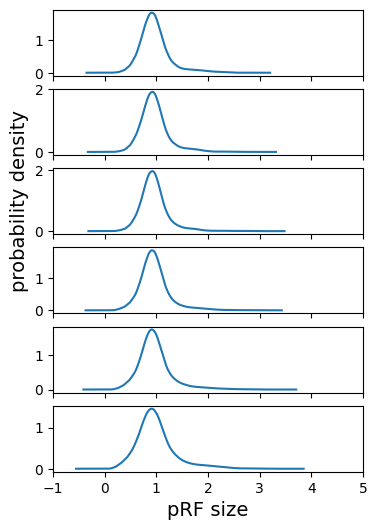

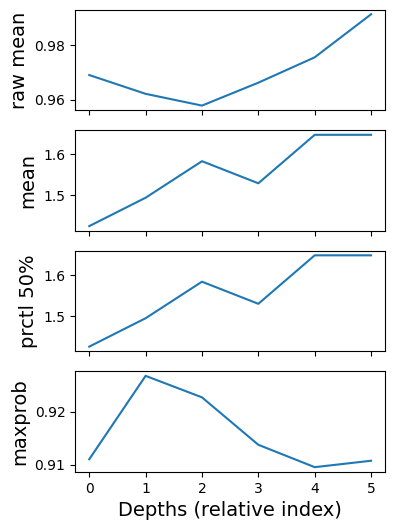

In [48]:
pRFsizes = V1_all_sigma_list
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

# CI array init
V1_CI_lower = np.zeros([n_depth,2])
V1_CI_upper = np.zeros([n_depth,2])
V1_SE = np.zeros([n_depth,2])
V1_SD = np.zeros([n_depth,2])
V1_HDI = np.zeros([n_depth,2])


fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    ax[n].set_xticks(np.arange(-1,6))
    if n != len(depth)-1 :
        ax[n].set_xticklabels([])
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
    
    # get 95% HDI (high density interval)
    data = np.array(X)
    data = data[np.isfinite(data)]
    
    density = dens.density
    kde = gaussian_kde(data)
    
    # Evaluate the density function at a range of values
    x = np.linspace(s.min(), s.max(), 1000)
    pdf = kde(x)
    
    # Find the 95% HDI
    q = 0.95
    cdf = np.cumsum(pdf) / np.sum(pdf)
    idx1 = np.argmin(np.abs(cdf - (1 - q) / 2))
    idx2 = np.argmin(np.abs(cdf - (1 + q) / 2))
    V1_HDI[n,:] = [x[idx1], x[idx2]]
    
    
    for meas in range(2):
        # get bootstrapped CI's
        V1_CI_lower[n,meas] = np.percentile(V1_maxprobs[n,:,meas], 2.5)
        V1_CI_upper[n,meas] = np.percentile(V1_maxprobs[n,:,meas], 97.5)

        V1_SE[n,meas] = np.std(V1_maxprobs[n,:,meas], ddof=1) / np.sqrt(n_boot)
        V1_SD[n,meas] = np.std(V1_maxprobs[n,:,meas], ddof=1) 
    
    
    
ax[2].set_ylabel('probability density', fontsize=14)
ax[5].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

V1_sigmas=sigmas

## V2

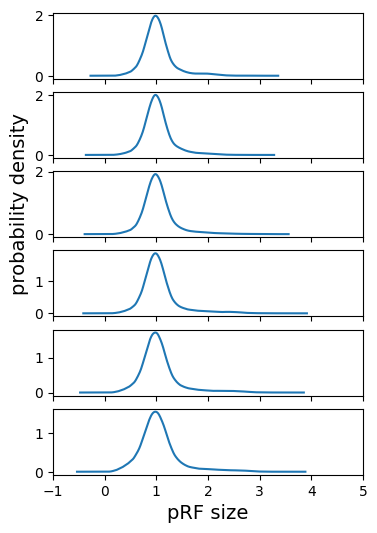

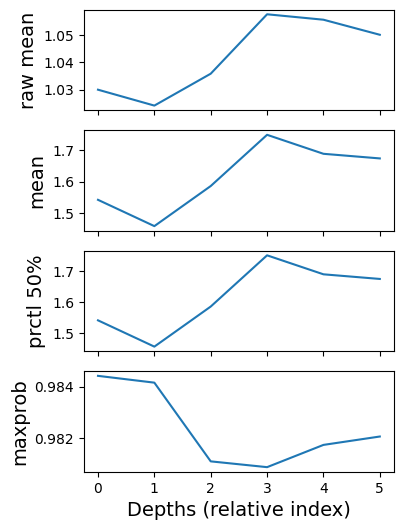

In [49]:
pRFsizes = V2_all_sigma_list
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

# CI array init
V2_CI_lower = np.zeros([n_depth,2])
V2_CI_upper = np.zeros([n_depth,2])
V2_SE = np.zeros([n_depth,2])
V2_SD = np.zeros([n_depth,2])
V2_HDI = np.zeros([n_depth,2])

fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    ax[n].set_xticks(np.arange(-1,6))
    if n != len(depth)-1 :
        ax[n].set_xticklabels([])
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
    
    # get 95% HDI (high density interval)
    data = np.array(X)
    data = data[np.isfinite(data)]
    
    density = dens.density
    kde = gaussian_kde(data)
    
    # Evaluate the density function at a range of values
    x = np.linspace(s.min(), s.max(), 1000)
    pdf = kde(x)
    
    # Find the 95% HDI
    q = 0.95
    cdf = np.cumsum(pdf) / np.sum(pdf)
    idx1 = np.argmin(np.abs(cdf - (1 - q) / 2))
    idx2 = np.argmin(np.abs(cdf - (1 + q) / 2))
    V2_HDI[n,:] = [x[idx1], x[idx2]]
    
    for meas in range(2):
        # get bootstrapped CI's
        V2_CI_lower[n,meas] = np.percentile(V2_maxprobs[n,:,meas], 2.5)
        V2_CI_upper[n,meas] = np.percentile(V2_maxprobs[n,:,meas], 97.5)

        V2_SE[n,meas] = np.std(V2_maxprobs[n,:,meas], ddof=1) / np.sqrt(n_boot)
        V2_SD[n,meas] = np.std(V2_maxprobs[n,:,meas], ddof=1) 
    
ax[2].set_ylabel('probability density', fontsize=14)
ax[5].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

V2_sigmas=sigmas

## V3

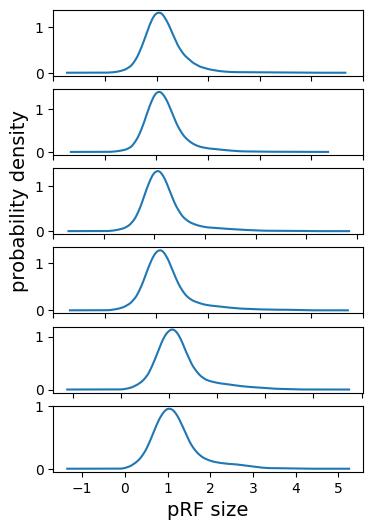

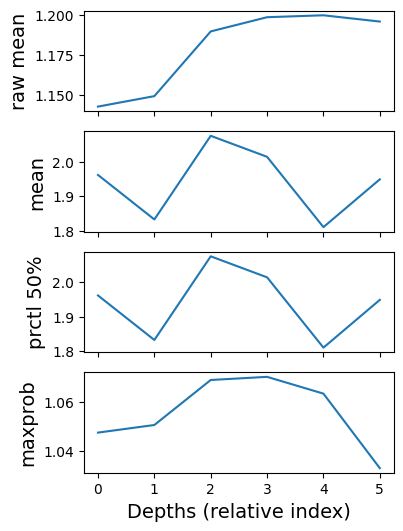

In [50]:
pRFsizes = V3_all_sigma_list
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

# CI array init
V3_CI_lower = np.zeros([n_depth,2])
V3_CI_upper = np.zeros([n_depth,2])
V3_SE = np.zeros([n_depth,2])
V3_SD = np.zeros([n_depth,2])
V3_HDI = np.zeros([n_depth,2])

fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    ax[n].set_xticks(np.arange(-1,6))
    if n != len(depth)-1 :
        ax[n].set_xticklabels([])
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
    
    # get 95% HDI (high density interval)
    data = np.array(X)
    data = data[np.isfinite(data)]
    
    density = dens.density
    kde = gaussian_kde(data)
    
    # Evaluate the density function at a range of values
    x = np.linspace(s.min(), s.max(), 1000)
    pdf = kde(x)
    
    # Find the 95% HDI
    q = 0.95
    cdf = np.cumsum(pdf) / np.sum(pdf)
    idx1 = np.argmin(np.abs(cdf - (1 - q) / 2))
    idx2 = np.argmin(np.abs(cdf - (1 + q) / 2))
    V3_HDI[n,:] = [x[idx1], x[idx2]]
    
    for meas in range(2):
        # get bootstrapped CI's
        V3_CI_lower[n,meas] = np.percentile(V3_maxprobs[n,:,meas], 2.5)
        V3_CI_upper[n,meas] = np.percentile(V3_maxprobs[n,:,meas], 97.5)

        V3_SE[n,meas] = np.std(V3_maxprobs[n,:,meas], ddof=1) / np.sqrt(n_boot)
        V3_SD[n,meas] = np.std(V3_maxprobs[n,:,meas], ddof=1) 
    
ax[2].set_ylabel('probability density', fontsize=14)
ax[5].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

V3_sigmas=sigmas

## V4

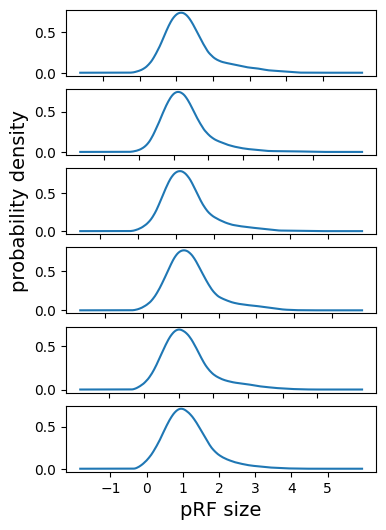

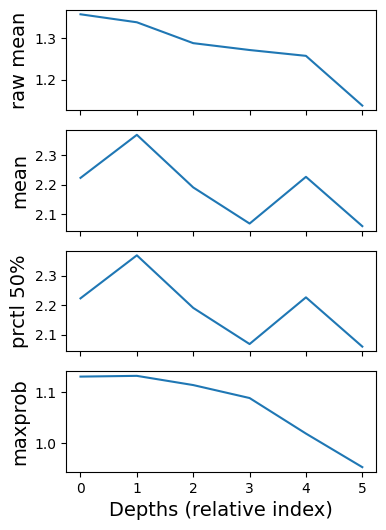

In [51]:
pRFsizes = V4_all_sigma_list
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

# CI array init
V4_CI_lower = np.zeros([n_depth,2])
V4_CI_upper = np.zeros([n_depth,2])
V4_SE = np.zeros([n_depth,2])
V4_SD = np.zeros([n_depth,2])
V4_HDI = np.zeros([n_depth,2])

fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    ax[n].set_xticks(np.arange(-1,6))
    if n != len(depth)-1 :
        ax[n].set_xticklabels([])
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
    
    # get 95% HDI (high density interval)
    data = np.array(X)
    data = data[np.isfinite(data)]
    
    density = dens.density
    kde = gaussian_kde(data)
    
    # Evaluate the density function at a range of values
    x = np.linspace(s.min(), s.max(), 1000)
    pdf = kde(x)
    
    # Find the 95% HDI
    q = 0.95
    cdf = np.cumsum(pdf) / np.sum(pdf)
    idx1 = np.argmin(np.abs(cdf - (1 - q) / 2))
    idx2 = np.argmin(np.abs(cdf - (1 + q) / 2))
    V4_HDI[n,:] = [x[idx1], x[idx2]]
    
    for meas in range(2):
        # get bootstrapped CI's
        V4_CI_lower[n,meas] = np.percentile(V4_maxprobs[n,:,meas], 2.5)
        V4_CI_upper[n,meas] = np.percentile(V4_maxprobs[n,:,meas], 97.5)

        V4_SE[n,meas] = np.std(V4_maxprobs[n,:,meas], ddof=1) / np.sqrt(n_boot)
        V4_SD[n,meas] = np.std(V4_maxprobs[n,:,meas], ddof=1) 
    
ax[2].set_ylabel('probability density', fontsize=14)
ax[5].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

V4_sigmas=sigmas

Text(0.5, 0, 'Depths (relative index)')

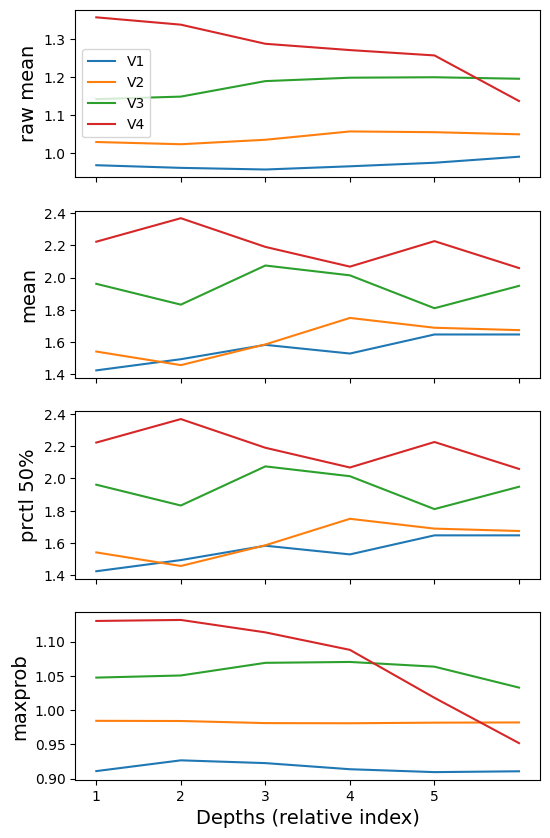

In [52]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(6, 10))
for n in range(4):
    ax[n].plot(V1_sigmas[:,n])
    ax[n].plot(V2_sigmas[:,n])
    ax[n].plot(V3_sigmas[:,n])
    ax[n].plot(V4_sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
    else:
        ax[n].set_xticks([0,1,2,3,4])
        ax[n].set_xticklabels([1,2,3,4,5])
    if n == 0 :
        ax[n].legend(['V1','V2','V3','V4'])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)


In [53]:
# fig = plt.figure()
# ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

# start_depth = 0
# meas = 0 #0 - mean, 1- max prob
# use_cortdist=False
# errorbar='SD' #'SE', 'SD', 'CI', 'HDI'
# if errorbar=='SE':
#     nr_ses = 3 # nr of standard errors of the mean
# elif errorbar=='SD':
#     nr_sds = 1 # nr of standard deviations of the mean
    
# # get list of cortical layers
# if start_depth==1:
#     x_allROI = np.arange(0,len(depth)-1)
# else:
#     x_allROI = np.arange(0,len(depth))

# if use_cortdist:
#     # get cortical distances in mm for each ROI
#     x_V1 = np.zeros([n_depth,])
#     x_V2 = np.zeros([n_depth,])
#     x_V3 = np.zeros([n_depth,])
#     x_V4 = np.zeros([n_depth,])
#     for n in range(0,len(depth)):
#         x_V1[n] = np.mean(V1_cortdist_list[n])
#         x_V2[n] = np.mean(V2_cortdist_list[n])
#         x_V3[n] = np.mean(V3_cortdist_list[n])
#         x_V4[n] = np.mean(V4_cortdist_list[n])
# else:
#     x_V1, x_V2, x_V3, x_V4 = x_allROI, x_allROI, x_allROI, x_allROI

# #V1
# hndl1,=ax.plot(x_V1,V1_sigmas[start_depth:,3])
# if errorbar=='CI':
#     ax.fill_between(x_V1, V1_CI_lower[start_depth:,], V1_CI_upper[start_depth:,],alpha=0.5)
# elif errorbar=='SE':
#     ax.fill_between(x_V1, V1_sigmas[start_depth:,3]-nr_ses*V1_SE[start_depth:,], V1_sigmas[start_depth:,3]+nr_ses*V1_SE[start_depth:,],alpha=0.5)
# elif errorbar=='SD':
#     ax.fill_between(x_V1, V1_sigmas[start_depth:,3]-nr_sds*V1_SD[start_depth:,], V1_sigmas[start_depth:,3]+nr_sds*V1_SD[start_depth:,],alpha=0.5)
# elif errorbar=='HDI':
#     ax.fill_between(x_V1, V1_HDI[start_depth:,0], V1_HDI[start_depth:,1],alpha=0.5)

# #V2
# hndl2,=ax.plot(x_V2,V2_sigmas[start_depth:,3])
# if errorbar=='CI':
#     ax.fill_between(x_V2, V2_CI_lower[start_depth:,], V2_CI_upper[start_depth:,],alpha=0.5)
# elif errorbar=='SE':
#     ax.fill_between(x_V2, V2_sigmas[start_depth:,3]-nr_ses*V2_SE[start_depth:,], V2_sigmas[start_depth:,3]+nr_ses*V2_SE[start_depth:,],alpha=0.5)
# elif errorbar=='SD':
#     ax.fill_between(x_V2, V2_sigmas[start_depth:,3]-nr_sds*V2_SD[start_depth:,], V2_sigmas[start_depth:,3]+nr_sds*V2_SD[start_depth:,],alpha=0.5)
# elif errorbar=='HDI':
#     ax.fill_between(x_V2, V2_HDI[start_depth:,0], V2_HDI[start_depth:,1],alpha=0.5)

# #V3
# hndl3,=ax.plot(x_V3,V3_sigmas[start_depth:,3])
# if errorbar=='CI':
#     ax.fill_between(x_V3, V3_CI_lower[start_depth:,], V3_CI_upper[start_depth:,],alpha=0.5)
# elif errorbar=='SE':
#     ax.fill_between(x_V3, V3_sigmas[start_depth:,3]-nr_ses*V3_SE[start_depth:,], V3_sigmas[start_depth:,3]+nr_ses*V3_SE[start_depth:,],alpha=0.5)
# elif errorbar=='SD':
#     ax.fill_between(x_V3, V3_sigmas[start_depth:,3]-nr_sds*V3_SD[start_depth:,], V3_sigmas[start_depth:,3]+nr_sds*V3_SD[start_depth:,],alpha=0.5)
# elif errorbar=='HDI':
#     ax.fill_between(x_V3, V3_HDI[start_depth:,0], V3_HDI[start_depth:,1],alpha=0.5)
    
# #V4
# hndl4,=ax.plot(x_V4,V4_sigmas[start_depth:,3])
# if errorbar=='CI':
#     ax.fill_between(x_V4, V4_CI_lower[start_depth:,], V4_CI_upper[start_depth:,],alpha=0.5)
# elif errorbar=='SE':
#     ax.fill_between(x_V4, V4_sigmas[start_depth:,3]-nr_ses*V4_SE[start_depth:,], V4_sigmas[start_depth:,3]+nr_ses*V4_SE[start_depth:,],alpha=0.5)
# elif errorbar=='SD':
#     ax.fill_between(x_V4, V4_sigmas[start_depth:,3]-nr_sds*V4_SD[start_depth:,], V4_sigmas[start_depth:,3]+nr_sds*V4_SD[start_depth:,],alpha=0.5)
# elif errorbar=='HDI':
#     ax.fill_between(x_V4, V4_HDI[start_depth:,0], V4_HDI[start_depth:,1],alpha=0.5)

# # add xticks and labels
# if use_cortdist:
#     n_ticks=8
#     ax.set_xticks(np.linspace(round(np.min(np.concatenate([x_V1,x_V2,x_V3,x_V4])),1),
#             round(np.max(np.concatenate([x_V1,x_V2,x_V3,x_V4])),1),n_ticks))
#     ax.set_xlabel('Cortical depth [mm]', fontsize=14)
# else:
#     ax.set_xlabel('Cortical depth bin (equi-volumetric)', fontsize=14)
#     if start_depth==1:
#         ax.set_xticks(np.arange(0,len(depth)-1))
#         ax.set_xticklabels(np.arange(1,len(depth)))
#     elif start_depth==0:
#         ax.set_xticks(np.arange(0,len(depth)))
#         ax.set_xticklabels(np.arange(1,len(depth)+1))

# # add ylabel, title, legend
# ax.set_ylabel('pRF size (FWHM in degrees)', rotation=90, fontsize=14)
# ax.legend([hndl1,hndl2,hndl3,hndl4],['V1','V2','V3','V4'])
# # if prf_model=='prfpy_Iso2DGaussianModel_LinearDeveining':
# #     ax.set_title('Iso-2D Gaussian pRF model, linear deveining')
# # elif prf_model=='prfpy_Iso2DGaussianModel':
# #     ax.set_title('Iso 2D Gaussian pRF model, no deveining')



### Separate plots for each ROI

prfpy_fit_hrf_True_start_from_avg_True


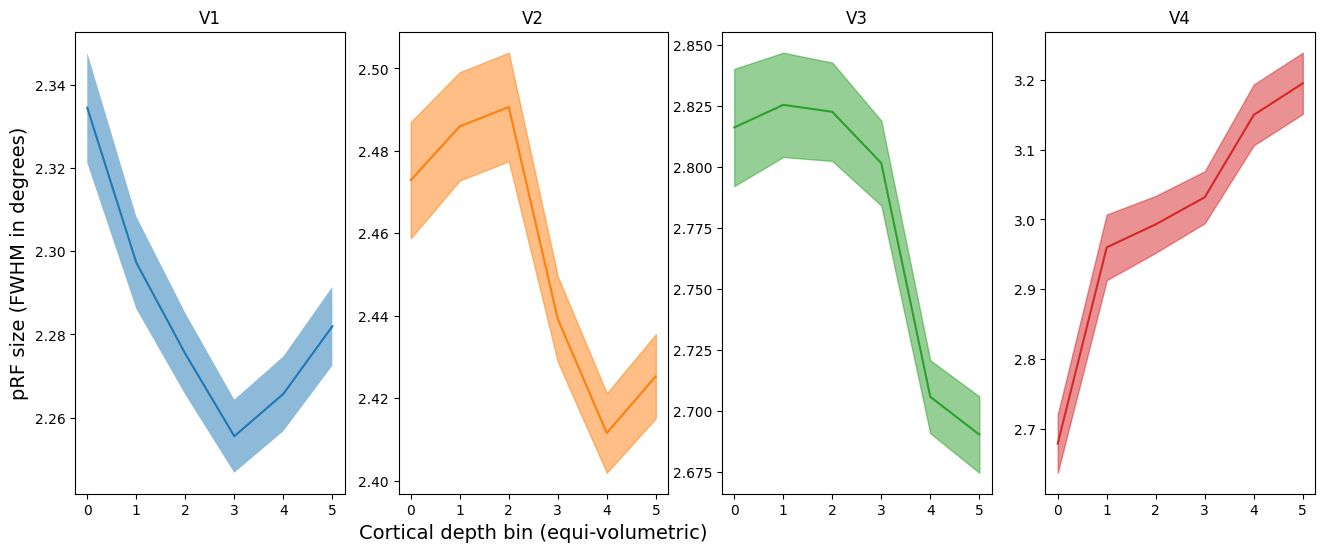

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(16, 6))

start_depth  = 0
meas         = 0 # 0 - raw mean, 1 - max prob 
FWHM         = True
errorbar     = 'SD' #'SE', 'SD', 'CI', 'HDI'
if space == 'surf':
    invert_x = True # for FS equivolumetric surfaces, 0 = pial surface and 1 = wm surface, therefore: invert x-axis
elif space == 'vol':
    invert_x = False
use_cortdist = False # not an option for FS equivolumetric analysis

if errorbar == 'SE':
    nr_ses = 3 # nr of standard errors of the mean
elif errorbar == 'SD':
    nr_sds = 1 # nr of standard deviations of the mean
if FWHM:
    scale_factor = np.sqrt(8*np.log(2))
else:
    scale_factor = 1
    
# get x coordinates list 
if start_depth == 1:
    x_allROI = np.arange(0,len(depth)-1)
else:
    x_allROI = np.arange(0,len(depth))
    

# invert x axis
if invert_x:
    x_allROI = x_allROI[::-1]

if use_cortdist:
    # get cortical distances in mm for each ROI
    x_V1 = np.zeros([n_depth,])
    x_V2 = np.zeros([n_depth,])
    x_V3 = np.zeros([n_depth,])
    x_V4 = np.zeros([n_depth,])
    for n in range(0,len(depth)):
        x_V1[n] = np.mean(V1_cortdist_list[n])
        x_V2[n] = np.mean(V2_cortdist_list[n])
        x_V3[n] = np.mean(V3_cortdist_list[n])
        x_V4[n] = np.mean(V4_cortdist_list[n])
else:
    x_V1, x_V2, x_V3, x_V4 = x_allROI, x_allROI, x_allROI, x_allROI

#V1
ax[0].set_title('V1')
ax[0].plot(x_V1,scale_factor*V1_sigmas[start_depth:,meas])
if errorbar=='CI':
    ax[0].fill_between(x_V1, scale_factor*V1_CI_lower[start_depth:,meas], scale_factor*V1_CI_upper[start_depth:,meas],alpha=0.5)
elif errorbar=='SE':
    ax[0].fill_between(x_V1, scale_factor*(V1_sigmas[start_depth:,meas]-nr_ses*V1_SE[start_depth:,meas]), scale_factor*(V1_sigmas[start_depth:,meas]+nr_ses*V1_SE[start_depth:,meas]),alpha=0.5)
elif errorbar=='SD':
    ax[0].fill_between(x_V1, scale_factor*(V1_sigmas[start_depth:,meas]-nr_sds*V1_SD[start_depth:,meas]), scale_factor*(V1_sigmas[start_depth:,meas]+nr_sds*V1_SD[start_depth:,meas]),alpha=0.5)
elif errorbar=='HDI':
    ax[0].fill_between(x_V1, scale_factor*V1_HDI[start_depth:,0], scale_factor*V1_HDI[start_depth:,1],alpha=0.5)

#V2
ax[1].set_title('V2')
ax[1].plot(x_V2,scale_factor*V2_sigmas[start_depth:,meas],color="C{}".format(1))
if errorbar=='CI':
    ax[1].fill_between(x_V2, scale_factor*V2_CI_lower[start_depth:,meas], scale_factor*V2_CI_upper[start_depth:,meas],alpha=0.5,color="C{}".format(1))
elif errorbar=='SE':
    ax[1].fill_between(x_V2, scale_factor*(V2_sigmas[start_depth:,meas]-nr_ses*V2_SE[start_depth:,meas]), scale_factor*(V2_sigmas[start_depth:,meas]+nr_ses*V2_SE[start_depth:,meas]),alpha=0.5,color="C{}".format(1))
elif errorbar=='SD':
    ax[1].fill_between(x_V2, scale_factor*(V2_sigmas[start_depth:,meas]-nr_sds*V2_SD[start_depth:,meas]), scale_factor*(V2_sigmas[start_depth:,meas]+nr_sds*V2_SD[start_depth:,meas]),alpha=0.5,color="C{}".format(1))
elif errorbar=='HDI':
    ax[1].fill_between(x_V2, scale_factor*V2_HDI[start_depth:,0], scale_factor*V2_HDI[start_depth:,1],alpha=0.5,color="C{}".format(1))

#V3
ax[2].set_title('V3')
ax[2].plot(x_V3,scale_factor*V3_sigmas[start_depth:,meas],color="C{}".format(2))
if errorbar=='CI':
    ax[2].fill_between(x_V3, scale_factor*V3_CI_lower[start_depth:,meas], scale_factor*V3_CI_upper[start_depth:,meas],alpha=0.5,color="C{}".format(2))
elif errorbar=='SE':
    ax[2].fill_between(x_V3, scale_factor*(V3_sigmas[start_depth:,meas]-nr_ses*V3_SE[start_depth:,meas]), scale_factor*(V3_sigmas[start_depth:,meas]+nr_ses*V3_SE[start_depth:,meas]),alpha=0.5,color="C{}".format(2))
elif errorbar=='SD':
    ax[2].fill_between(x_V3, scale_factor*(V3_sigmas[start_depth:,meas]-nr_sds*V3_SD[start_depth:,meas]), scale_factor*(V3_sigmas[start_depth:,meas]+nr_sds*V3_SD[start_depth:,meas]),alpha=0.5,color="C{}".format(2))
elif errorbar=='HDI':
    ax[2].fill_between(x_V3, scale_factor*V3_HDI[start_depth:,0], scale_factor*V3_HDI[start_depth:,1],alpha=0.5,color="C{}".format(2))

#V4
ax[3].set_title('V4')
ax[3].plot(x_V4,scale_factor*V4_sigmas[start_depth:,meas],color="C{}".format(3))
if errorbar=='CI':
    ax[3].fill_between(x_V4, scale_factor*V4_CI_lower[start_depth:,meas], scale_factor*V4_CI_upper[start_depth:,meas],alpha=0.5,color="C{}".format(3))
elif errorbar=='SE':
    ax[3].fill_between(x_V4, scale_factor*(V4_sigmas[start_depth:,meas]-nr_ses*V4_SE[start_depth:,meas]), scale_factor*(V4_sigmas[start_depth:,meas]+nr_ses*V4_SE[start_depth:,meas]),alpha=0.5,color="C{}".format(3))
elif errorbar=='SD':
    ax[3].fill_between(x_V4, scale_factor*(V4_sigmas[start_depth:,meas]-nr_sds*V4_SD[start_depth:,meas]), scale_factor*(V4_sigmas[start_depth:,meas]+nr_sds*V4_SD[start_depth:,meas]),alpha=0.5,color="C{}".format(3))
elif errorbar=='HDI':
    ax[3].fill_between(x_V4, scale_factor*V4_HDI[start_depth:,0], scale_factor*V4_HDI[start_depth:,1],alpha=0.5,color="C{}".format(3))

    
# add xticks and labels
if use_cortdist:
    n_ticks=8
    for i in range(0,n_rois):
        ax[i].set_xticks(np.linspace(round(np.min(np.concatenate([x_V1,x_V2,x_V3,x_V3])),1),
                round(np.max(np.concatenate([x_V1,x_V2,x_V3,x_V4])),1),n_ticks))
        ax[i].set_xlabel('Cortical depth [mm]', fontsize=14)
else:
    for i in range(0,n_rois):
        if start_depth==1:
            ax[i].set_xticks(np.arange(0,len(depth)-1))
            ax[i].set_xticklabels(np.arange(1,len(depth)))
        #elif start_depth==0:
            #ax[i].set_xticks(np.arange(0,len(depth)+1))
            #ax[i].set_xticklabels(np.arange(1,len(depth)+1))
ax[1].set_xlabel('Cortical depth bin (equi-volumetric)', fontsize=14)

# add ylabel, title, legend
ax[0].set_ylabel('pRF size (FWHM in degrees)', rotation=90, fontsize=14)
# if prf_model=='prfpy_Iso2DGaussianModel_LinearDeveining':
#     ax.set_title('Iso-2D Gaussian pRF model, linear deveining')
# elif prf_model=='prfpy_Iso2DGaussianModel':
#     ax.set_title('Iso 2D Gaussian pRF model, no deveining')
print(prf_model)

In [55]:
# hem_id      = 0
# sub_id      = 0
# out_dir     = opj(proj_dir,'output',prf_model,subject_list[sub_id])


# grid_fit_avg_fn      = opj(out_dir,hem_list[hem_id]+'_grid_fit_avg.pckl')
# iterative_fit_avg_fn = opj(out_dir,hem_list[hem_id]+'_iterative_fit_avg.pckl')
# pRF_param_avg_fn     = opj(out_dir,hem_list[hem_id]+'_pRF_params_avg.pckl')


# grid_fit_per_depth_fn      = opj(out_dir,hem_list[hem_id]+'_grid_fit_per_depth.pckl')
# iterative_fit_per_depth_fn = opj(out_dir,hem_list[hem_id]+'_iterative_fit_per_depth.pckl')
# pRF_param_per_depth_fn     = opj(out_dir,hem_list[hem_id]+'_pRF_params_per_depth.pckl')

In [56]:
# if fit_hrf:
#     f = open(iterative_fit_avg_fn,'rb')
#     gf = pickle.load(f)

In [57]:
# plt.hist(gf.gridsearch_params[:,4])

In [58]:
# gf.iterative_search_params.shape

In [59]:
# plt.hist(gf.gridsearch_params[:,5])

In [60]:
# plt.hist(gf.iterative_search_params[:,5])